## 3.2. Выявление аномалий в трафике транспортных средств методами машинного обучения

## Введение в предметную область

В условиях глобализации и роста международных грузоперевозок таможенный контроль играет ключевую роль в обеспечении безопасности, предотвращении контрабанды и оптимизации логистических процессов. Особое внимание уделяется мониторингу транспортных средств, пересекающих границы, поскольку их траектории движения могут содержать важную информацию о потенциальных нарушениях или нештатных ситуациях.

Одним из перспективных направлений в этой сфере является применение методов искусственного интеллекта (ИИ) для анализа данных о перемещении грузового транспорта. Использование ИИ позволяет автоматизировать обработку больших массивов информации, выявлять аномалии в маршрутах и прогнозировать риски, связанные с несанкционированным изменением пути следования.

Для анализа движения транспортных средств при помощи методов искусственного интеллекта используется набор файлов формата CSV.
Каждый файл представляет собой один маршрут или траекторию маршрута, в которых точка начала и точка окончания одинакова.

В данном примере общая протяжённость маршрута составляет около 4,6 - 5 км, используется 17 таких файлов с маршрутами:
1. ideal_mnogo_to4ek.csv - эталонная траектория, соответствующая заявленному плану перевозки.
2. actual1_mnogo_to4ek.csv, actual2_mnogo_to4ek.csv, actual3_mnogo_to4ek.csv, actual4_mnogo_to4ek.csv, actual5_mnogo_to4ek.csv, actual6_mnogo_to4ek.csv, actual7_mnogo_to4ek.csv, actual8_mnogo_to4ek.csv, actual9_mnogo_to4ek.csv, actual10_mnogo_to4ek.csv, actual11_mnogo_to4ek.csv, actual12_mnogo_to4ek.csv, actual13_mnogo_to4ek.csv, actual14_mnogo_to4ek.csv, actual15_mnogo_to4ek.csv, actual16_mnogo_to4ek.csv - реальные данные GPS-трекинга, которые могут отличаться от ожидаемого пути.

Каждый файл содержит три столбца с данными:
1. X - данные по координате X;
2. Y - данные по координате Y;
3. NULL-столбец - зарезервированное поле для дополнительных данных. 

Каждый из файлов фактических маршрутов содержит от 8-ти до 480-ти координатных точек.
В то время как количество точек в идеальной траектории - около 200.
Запись ведётся в файл с периодичностью 5-15 минут, а при пересечении границы или зон таможенного контроля происходит увеличение частоты передачи (например, до 1–5 минут).

Таким образом, все используемые файлы имеют следующий общий вид:

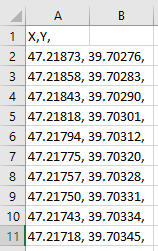

В файлах с координатами, где значения указаны с 5 знаками после запятой, используется десятичное представление градусов (например, 47.22241). 
То есть. это означает, что точность координат:
1 десятичный знак: ~11.1 км
2 знака: ~1.1 км;
3 знака: ~111 м;
4 знака: ~11 м;
5 знаков: ~1.1 м;
6 знаков: ~0.11 м (11 см).
Таким образом, 5 знаков после запятой дают точность около 1 метра, что вполне достаточно для анализа движения транспортных средств.
Тем более, для городских маршрутов отклонения в 1–2 метра не критичны (например, перестроение между полосами).

Цель работы
Разработка алгоритма на основе ИИ, способного:
- сравнивать реальные траектории с эталонными;
- обнаруживать аномалии (незапланированные остановки, отклонения от маршрута);
- формировать сигналы для таможенных служб при выявлении подозрительной активности.

### 1. Подключение необходимых библиотек для анализа пространственных данных и кластеризации траекторий транспортных средств.

1. Обработка данных:
pandas, numpy — загрузка и манипуляции с CSV-файлами траекторий.
StandardScaler — нормализация координат (X, Y), а также полученных при расчётах значений.

2. Кластеризация и анализ маршрутов:
DBSCAN, OPTICS, KMeans — выявление типовых траекторий и аномалий.
NearestNeighbors, pairwise_distances — расчёт расстояний между точками.

3. Визуализация:
matplotlib, seaborn — графики кластеров и отклонений.
folium, MarkerCluster — интерактивные карты с отображением маршрутов.

4. Метрики сравнения траекторий:
directed_hausdorff, geodesic — оценка схожести идеального и реальных маршрутов.

5. sklearn.metrics: Метрики для оценки кластеризации:
silhouette_score — коэффициент силуэта (чем ближе к 1, тем лучше)
calinski_harabasz_score — индекс Калински-Харабаша (чем выше, тем лучше)
davies_bouldin_score — индекс Дэвиса-Болдина (чем ближе к 0, тем лучше)

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import folium
from folium.plugins import MarkerCluster
from scipy.spatial.distance import directed_hausdorff
from geopy.distance import geodesic
import seaborn as sns

### 2. Загрузка и первичный анализ данных

Данный фрагмент кода выполняет загрузку и первичный анализ данных о траекториях движения транспортных средств, используемых для таможенного контроля. Он состоит из двух ключевых частей:
1. Импорт данных из CSV-файлов.
2. Предварительная проверка структуры и содержимого данных.

1. Загрузка данных

Объекты и их назначение
   ideal — загружает эталонную траекторию (ideal_mnogo_to4ek.csv), которая представляет собой идеальный маршрут, утверждённый для таможенного контроля.
   actual_1 – actual_16 — загружают фактические траектории (actual1_mnogo_to4ek.csv – actual16_mnogo_to4ek.csv), содержащие реальные GPS-координаты транспортных средств, пересекающих границу.
Для чтения CSV-файлов используется библиотека pandas с явным указанием разделителя sep=','.

2. Проверка данных

Целями данного этапа является:
- убедиться, что все файлы имеют одинаковый формат (столбцы X, Y, NULL);
- проверить типы данных (например, что X и Y — числа, а не строки);
- вывести первые 5 строк для быстрого понимания содержимого (на примере ideal и actual_1).

При этом применяются такие методы проверки, как:
- dtypes — выводит типы данных каждого столбца (например, float64 для координат);
- head() — отображает первые 5 строк таблицы, что позволяет: увидеть примеры координати визуально оценить наличие/отсутствие аномалий (например, нулевые значения).

Предметная значимость этого этапа заключается в том, что корректная загрузка данных и чтение их из файлов определённого формата - первый шаг для применения алгоритмов кластеризации (например, DBSCAN) и расчёта метрик (например, расстояние Хаусдорфа).

In [2]:
ideal = pd.read_csv("data/ideal_mnogo_to4ek.csv", sep=',')
actual_1 = pd.read_csv("data/actual1_mnogo_to4ek.csv", sep=',')
actual_2 = pd.read_csv("data/actual2_mnogo_to4ek.csv", sep=',')
actual_3 = pd.read_csv("data/actual3_mnogo_to4ek.csv", sep=',')
actual_4 = pd.read_csv("data/actual4_mnogo_to4ek.csv", sep=',')
actual_5 = pd.read_csv("data/actual5_mnogo_to4ek.csv", sep=',')
actual_6 = pd.read_csv("data/actual6_mnogo_to4ek.csv", sep=',')
actual_7 = pd.read_csv("data/actual7_mnogo_to4ek.csv", sep=',')
actual_8 = pd.read_csv("data/actual8_mnogo_to4ek.csv", sep=',')
actual_9 = pd.read_csv("data/actual9_mnogo_to4ek.csv", sep=',')
actual_10 = pd.read_csv("data/actual10_mnogo_to4ek.csv", sep=',')
actual_11 = pd.read_csv("data/actual11_mnogo_to4ek.csv", sep=',')
actual_12 = pd.read_csv("data/actual12_mnogo_to4ek.csv", sep=',')
actual_13 = pd.read_csv("data/actual13_mnogo_to4ek.csv", sep=',')
actual_14 = pd.read_csv("data/actual14_mnogo_to4ek.csv", sep=',')
actual_15 = pd.read_csv("data/actual15_mnogo_to4ek.csv", sep=',')
actual_16 = pd.read_csv("data/actual16_mnogo_to4ek.csv", sep=',')

print("Типы столбцов ideal_mnogo_to4ek.csv:")
print(ideal.dtypes)
print("Первые 5 строк из ideal_mnogo_to4ek.csv:")
print(ideal.head())

print("\nТипы столбцов actual1_mnogo_to4ek.csv:")
print(actual_1.dtypes)
print("\nПервые 5 строк из actual1_mnogo_to4ek.csv:")
print(actual_1.head())

print("\nТипы столбцов actual2_mnogo_to4ek.csv:")
print(actual_2.dtypes)
# print("\nПервые 5 строк из actual2_mnogo_to4ek.csv:")
# print(actual_2.head())

print("\nТипы столбцов actual3_mnogo_to4ek.csv:")
print(actual_3.dtypes)
# print("\nПервые 5 строк из actual3_mnogo_to4ek.csv:")
# print(actual_3.head())

print("\nТипы столбцов actual4_mnogo_to4ek.csv:")
print(actual_4.dtypes)
# print("\nПервые 5 строк из actual4_mnogo_to4ek.csv:")
# print(actual_4.head())

print("\nТипы столбцов actual5_mnogo_to4ek.csv:")
print(actual_5.dtypes)
# print("\nПервые 5 строк из actual5_mnogo_to4ek.csv:")
# print(actual_5.head())

print("\nТипы столбцов actual6_mnogo_to4ek.csv:")
print(actual_6.dtypes)
# print("\nПервые 5 строк из actual6_mnogo_to4ek.csv:")
# print(actual_6.head())

print("\nТипы столбцов actual7_mnogo_to4ek.csv:")
print(actual_7.dtypes)
# print("\nПервые 5 строк из actual7_mnogo_to4ek.csv:")
# print(actual_7.head())

print("\nТипы столбцов actual8_mnogo_to4ek.csv:")
print(actual_8.dtypes)
# print("\nПервые 5 строк из actual8_mnogo_to4ek.csv:")
# print(actual_8.head())

print("\nТипы столбцов actual9_mnogo_to4ek.csv:")
print(actual_9.dtypes)

print("\nТипы столбцов actual10_mnogo_to4ek.csv:")
print(actual_10.dtypes)

print("\nТипы столбцов actual11_mnogo_to4ek.csv:")
print(actual_11.dtypes)

print("\nТипы столбцов actual12_mnogo_to4ek.csv:")
print(actual_12.dtypes)

print("\nТипы столбцов actual13_mnogo_to4ek.csv:")
print(actual_13.dtypes)

print("\nТипы столбцов actual14_mnogo_to4ek.csv:")
print(actual_14.dtypes)

print("\nТипы столбцов actual15_mnogo_to4ek.csv:")
print(actual_15.dtypes)

print("\nТипы столбцов actual16_mnogo_to4ek.csv:")
print(actual_16.dtypes)

Типы столбцов ideal_mnogo_to4ek.csv:
X    float64
Y    float64
dtype: object
Первые 5 строк из ideal_mnogo_to4ek.csv:
          X         Y
0  47.21873  39.70276
1  47.21867  39.70279
2  47.21861  39.70282
3  47.21857  39.70284
4  47.21852  39.70286

Типы столбцов actual1_mnogo_to4ek.csv:
X    float64
Y    float64
dtype: object

Первые 5 строк из actual1_mnogo_to4ek.csv:
          X         Y
0  47.21874  39.70275
1  47.21866  39.70278
2  47.21858  39.70282
3  47.21852  39.70285
4  47.21846  39.70288

Типы столбцов actual2_mnogo_to4ek.csv:
X    float64
Y    float64
      object
dtype: object

Типы столбцов actual3_mnogo_to4ek.csv:
X    float64
Y    float64
      object
dtype: object

Типы столбцов actual4_mnogo_to4ek.csv:
X    float64
Y    float64
      object
dtype: object

Типы столбцов actual5_mnogo_to4ek.csv:
X    float64
Y    float64
      object
dtype: object

Типы столбцов actual6_mnogo_to4ek.csv:
X    float64
Y    float64
      object
dtype: object

Типы столбцов actual7_mnogo_

### 3. Визуализация эталонного маршрута

Цель:
Создание интерактивной карты для наглядного отображения идеального (эталонного) маршрута транспортного средства, включая его начальную и конечную точки.

Предметная цель:
1. Визуальная верификация маршрута:
- убедиться, что эталонная траектория соответствует заявленному пути перемещения груза;
- определить ключевые точки (старт и финиш), которые будут использоваться для сравнения с фактическими маршрутами.
2. Подготовка базы для анализа отклонений:
Карта служит основой для последующего наложения реальных траекторий и выявления несоответствий.

Программный код, представленный в следующей ячейке реализует:

1. Расчет центра карты
Первым делом в переменную map_center записывается средняя точка маршрута, определённая по координатам эталонного маршрута.
Это необходимо для оптимального отображения.

2. Создание карты
Инициализация карты с центром в map_center и масштабом zoom_start=13.
folium.Map() — конструктор карты из библиотеки Folium.
Параметры:
- location=map_center. Центр карты задается координатами [широта, долгота]. Обычно вычисляется как среднее значений ideal['X'] и ideal['Y'].
- zoom_start=13. Уровень масштабирования (13 — оптимален для городских маршрутов). Диапазон значений: 1 (весь мир) — 18 (уровень улиц).

3. Отрисовка эталонного маршрута (PolyLine)
folium.PolyLine() — метод для рисования ломаных линий.
Параметры:
- locations=ideal[['X', 'Y']].values. Преобразует DataFrame с координатами в массив NumPy. Формат: [[x1,y1], [x2,y2], ..., [xn,yn]].
- color='red'. Цвет линии (красный — стандарт для эталонов). Альтернативы: HEX-коды ('#FF0000') или названия ('blue').
- weight=5. Толщина линии в пикселях.
- opacity=0.8. Прозрачность (0.0 — невидимая, 1.0 — полностью непрозрачная).
- tooltip='Ideal Route'. Текст, появляющийся при наведении курсора на линию.
- .add_to(m_ideal). Привязывает линию к созданной карте.
Результат 3-го шага: маршрут отображается красной линией толщиной 5px с подсказкой при наведении.

4. Получение первой и последней точки маршрута
iloc — метод для доступа к данным по их порядковому номеру (а не по метке).
Таким образом, для начальной точки (start_point):
ideal['X'] — обращение к столбцу X (долгота) в DataFrame ideal.
.iloc[0] — выбор первого элемента (индекс 0) из этого столбца.
Аналогично для координаты Y: ideal['Y'].iloc[0] — первая широта.
Результат: список [longitude, latitude], например, [55.75, 37.62].

Для конечной точки (end_point):
.iloc[-1] — выбор последнего элемента (индекс -1, так как в Python отрицательные индексы отсчитываются с конца (-1 — последний элемент, -2 — предпоследний и т.д.).
Результат: координаты последней точки маршрута, например, [55.85, 37.70].
Общий результат 4-го шага - два списка с начальными  и конечными координатами соответственно. 

5. Добавление маркеров начала и конца маршрута (красная иконка "Play" и красная иконка "Stop" соответственно)
Полученные на предыдущем шаге точки используются для добавления маркеров на карту.
Данный фрагмент добавляет на интерактивную карту m_ideal два визуальных маркера:
Стартовая точка маршрута (иконка "play").
Конечная точка маршрута (иконка "stop").

Цель:
Наглядно выделить ключевые точки эталонного маршрута для:
- быстрой идентификации начала и конца пути;
- последующего сравнения с фактическими маршрутами в таможенном анализе.

Для создания маркеров используются параметры folium.Marker, имеющие следующую общую структуру:
folium.Marker(
    location=координаты (Список из двух элементов [широта (Y), долгота (X)]),
    icon=настройки_иконки (color — цвет иконки, icon — тип иконки, prefix — библиотека иконок),
    tooltip=текст_подсказки (Строка с текстом, который появляется при наведении на маркер)
).add_to(карта)

Для стартовой точки:
location=start_point - координаты [широта, долгота];
icon=folium.Icon(
        color='red', - цвет иконки;
        icon='play', - тип иконки;
        prefix='fa'  - библиотека иконок (Font Awesome 4 (используется по умолчанию в folium));
    ),
tooltip=f'Start: {start_point}' - всплывающая подсказка;
метод .add_to(m_ideal)  реализует привязку к карте m_ideal.

Для конечной точки:
location=end_point - координаты [широта, долгота];
icon=folium.Icon(
        color='red', - цвет иконки;
        icon='stop', - тип иконки;
        prefix='fa'  - библиотека иконок (Font Awesome 4 (используется по умолчанию в folium));
    ),
tooltip=f'End: {end_point}' - всплывающая подсказка;
метод .add_to(m_ideal)  реализует привязку к карте m_ideal.

6. Отображение карты (display)
Вывод интерактивной карты в Jupyter Notebook.

In [3]:
# 1. Расчет центра карты
map_center = [ideal['X'].mean(), ideal['Y'].mean()]

# 2. Создание карты
# 3. Карта с идеальным маршрутом (красная линия)
m_ideal = folium.Map(location=map_center, zoom_start=13)
folium.PolyLine(
    locations=ideal[['X', 'Y']].values,
    color='red',
    weight=5,
    opacity=0.8,
    tooltip='Ideal Route'
).add_to(m_ideal)

# 4. Получение первой и последней точки маршрута
start_point = [ideal['X'].iloc[0], ideal['Y'].iloc[0]]
end_point = [ideal['X'].iloc[-1], ideal['Y'].iloc[-1]]

# 5. Добавление маркеров начала и конца маршрута (красная иконка "Play" и красная иконка "Stop" соответственно)
folium.Marker(
    location=start_point,
    icon=folium.Icon(color='red', icon='play', prefix='fa'),
    tooltip=f'Start: {start_point}'
).add_to(m_ideal)

folium.Marker(
    location=end_point,
    icon=folium.Icon(color='red', icon='stop', prefix='fa'),
    tooltip=f'End: {end_point}'
).add_to(m_ideal)

# 6. Отображение карты (display)
display(m_ideal)


### 4. Пример реализации одного из фактических маршрутов

Следующий фрагмент кода предназначен для сравнительного анализа движения транспортного средства.
Он создает интерактивную карту с фактически пройденным маршрутом (файл actual1_mnogo_to4ek.csv).

1. Создание карты
2. Карта с фактическим маршрутом (actual_1)
Карта центрируется на средних координатах эталонного маршрута, рассчитанных на предыдущем этапе (для согласованного отображения).
zoom_start=13 — оптимальный масштаб для просмотра городских маршрутов (охват ~5-10 км).

folium.PolyLine() — метод для рисования ломаных линий.
Параметры:
- locations=ideal[['X', 'Y']].values. Преобразует DataFrame с координатами в массив NumPy. Формат: [[x1,y1], [x2,y2], ..., [xn,yn]].
- color='blue'. Цвет линии (синий). Альтернативы: HEX-коды ('#FF0000') или названия ('red', 'pink').
- weight=5. Толщина линии в пикселях.
- opacity=0.8. Прозрачность (0.0 — невидимая, 1.0 — полностью непрозрачная).
- tooltip='Ideal Route'. Текст, появляющийся при наведении курсора на линию.
- .add_to(m_actual_1). Привязывает линию к созданной карте.

3. Получение первой и последней точки маршрута
iloc — уже знакомый и используемый на предыдущем этапе метод доступа к данным по их порядковому номеру.
Таким образом, для начальной точки (start_point):
actual_1['X'] — обращение к столбцу X (долгота) в DataFrame actual_1.
.iloc[0] — выбор первого элемента (индекс 0) из этого столбца.
Аналогично для координаты Y: actual_1['Y'].iloc[0] — первая широта.
Результат: список [longitude, latitude], например, [55.75, 37.62].

Для конечной точки (end_point):
.iloc[-1] — выбор последнего элемента (индекс -1, так как в Python отрицательные индексы отсчитываются с конца (-1 — последний элемент, -2 — предпоследний и т.д.).
Результат: координаты последней точки маршрута, например, [55.85, 37.70].
Общий результат 3-го шага - два списка с начальными  и конечными координатами соответственно. 

4. Добавление маркеров начала и конца маршрута (синяя иконка "Play" и синяя иконка "Stop" соответственно)
Полученные на предыдущем шаге точки используются для добавления маркеров на карту.
Данный фрагмент добавляет на интерактивную карту m_ideal два визуальных маркера:
Стартовая точка маршрута (иконка "play").
Конечная точка маршрута (иконка "stop").

Для создания маркеров используются параметры folium.Marker, имеющие следующую общую структуру:
folium.Marker(
    location=координаты (Список из двух элементов [широта (Y), долгота (X)]),
    icon=настройки_иконки (color — цвет иконки, icon — тип иконки, prefix — библиотека иконок),
    tooltip=текст_подсказки (Строка с текстом, который появляется при наведении на маркер)
).add_to(карта)

5. Отображение карты (display)
Вывод интерактивной карты в Jupyter Notebook.

In [4]:
# 1. Создание карты
# 2. Карта с фактическим маршрутом (actual_1)
m_actual_1 = folium.Map(location=map_center, zoom_start=13)
folium.PolyLine(
    locations=actual_1[['X', 'Y']].values,
    color='blue',
    weight=5,
    opacity=0.8,
    tooltip='Actual1 Route'
).add_to(m_actual_1)

# 3. Получение первой и последней точки маршрута
start_point = [actual_1['X'].iloc[0], actual_1['Y'].iloc[0]]
end_point = [actual_1['X'].iloc[-1], actual_1['Y'].iloc[-1]]

# 4. Добавление маркеров начала и конца маршрута (синяя иконка "Play" и синяя иконка "Stop" соответственно)
folium.Marker(
    location=start_point,
    icon=folium.Icon(color='blue', icon='play', prefix='fa'),
    tooltip=f'Start: {start_point}'
).add_to(m_actual_1)

folium.Marker(
    location=end_point,
    icon=folium.Icon(color='blue', icon='stop', prefix='fa'),
    tooltip=f'End: {end_point}'
).add_to(m_actual_1)

# 5. Отображение карты (display)
display(m_actual_1)


### 5. Анализ маршрутов транспортных средств

#### 5.1. Интерполяция маршрута на N точек

Функция решает задачу нормализации маршрутов для последующего анализа путем:
- приведения траекторий к единому числу точек (устранение зависимости от частоты GPS-замеров);
- сохранения геометрической формы исходного пути;
- подготовки данных для точного сравнения маршрутов (например, расчета отклонений).

Функция выполняет линейную интерполяцию маршрута на заданное количество точек (num_points).

1. Расчет кумулятивных расстояний
Создается массив distances, где каждый элемент — суммарное расстояние от начала маршрута до текущей точки.
Используется функцию geodesic для точного расчета расстояния между координатами в метрах.

2. Генерация целевых расстояний (создание равномерно распределенных точек по расстоянию)
total_distance — общая длина маршрута.
step — расстояние между новыми точками после интерполяции.
target_distances — массив равномерно распределенных расстояний (0, step, 2*step, ..., total_distance).

3. Линейная интерполяция
1) Поиск сегмента
np.searchsorted находит индекс (idx) отрезка исходного маршрута, содержащего целевую дистанцию dist.
2) Защита от граничных случаев:
max(0, min(...)) предотвращает выход за пределы массива.
3) Проверка совпадающих точек:
Если точки совпадают (расстояние = 0), берется одна из них.
4) Интерполяция координат:
ratio — доля пройденного расстояния в сегменте.
Линейно интерполируются широта (lat) и долгота (lon).
Использует входные параметры:
- route - исходный маршрут (широта, долгота);
- num_points - количество точек после интерполяции.

Возвращаемое значение: interpolated_points — список кортежей (широта, долгота) длины num_points.
В данном списке точки равномерно распределены по длине маршрута, при этом сохраняется геометрическая форма исходной траектории.

После выполнения функции получаем следующий результат:
Исходный маршрут из N точек преобразуется в новый маршрут из num_points точек.
Расстояния между точками становятся одинаковыми:
Для num_points=5 и маршрута 100 м: точки на 0, 25, 50, 75, 100 м.

In [5]:
# Функция для интерполяции маршрута на N точек
def interpolate_route(route, num_points):
    # 1. Расчет кумулятивных расстояний
    distances = np.zeros(len(route))
    for i in range(1, len(route)):
        distances[i] = distances[i-1] + geodesic(route[i-1], route[i]).meters
    
    # 2. Генерация целевых расстояний (создание равномерно распределенных точек по расстоянию)
    total_distance = distances[-1]
    step = total_distance / (num_points - 1)
    target_distances = np.arange(0, total_distance + step, step)
    
    # 3. Линейная интерполяция
    interpolated_points = []
    for dist in target_distances:
        # Поиск сегмента, в котором находится текущее расстояние
        idx = np.searchsorted(distances, dist) - 1
        idx = max(0, min(idx, len(route)-2))
        
        if distances[idx+1] == distances[idx]:
            # Если точки совпадают, берётся одна из них
            interpolated_points.append(route[idx])
        else:
            # Линейная интерполяция между точками
            ratio = (dist - distances[idx]) / (distances[idx+1] - distances[idx])
            lat = route[idx][0] + ratio * (route[idx+1][0] - route[idx][0])
            lon = route[idx][1] + ratio * (route[idx+1][1] - route[idx][1])
            interpolated_points.append((lat, lon))
    
    return interpolated_points

#### 5.2. Количественная оценка суммарного отклонения фактического маршрута от эталонного

Следующая функция предназначена для количественной оценки суммарного отклонения фактического маршрута от эталонного.

Ключевые задачи:
- расчет общей "стоимости" отклонений (в метрах) для принятия решений в таможенном контроле;
- оценка кумулятивного эффекта мелких отклонений (например, систематическое смещение маршрута);
- подготовка данных для сравнительного анализа множества маршрутов.

Данная функция вычисляет сумму геодезических расстояний между парными точками двух маршрутов.

Входные данные функции:
- ideal_points - эталонный маршрут (широта, долгота);
- actual_points - фактический маршрут (широта, долгота).

1. zip(ideal_points, actual_points):
Создает пары вида (ideal_pt1, actual_pt1), (ideal_pt2, actual_pt2), ....
Требование: маршруты должны иметь одинаковое количество точек (предварительно нормализованы через interpolate_route)

2. geodesic(ideal_pt, actual_pt).meters:
Вычисляет расстояние на сфере Земли по формуле Винсенти.
Возвращает значение в метрах (.meters).

3. sum(distances):
Агрегирует все отклонения в единый показатель.

Возвращаемое значение
sum(distances) (float) — суммарное отклонение в метрах.
Интерпретация:
- 0 — маршруты полностью совпадают.
- 100-500 м — незначительные отклонения (погрешность GPS).
- >1 км — требует проверки.


In [6]:
# Функция для вычисления суммы расстояний между точками маршрутов
def calculate_s(ideal_points, actual_points):
    distances = []
    for ideal_pt, actual_pt in zip(ideal_points, actual_points):
        distance = geodesic(ideal_pt, actual_pt).meters
        distances.append(distance)
    return sum(distances)

Следующий фрагмент кода выполняет преобразование структуры данных для подготовки к геопространственному анализу.

Переводит координаты из формата раздельных столбцов DataFrame (X и Y) в формат списка кортежей (широта, долгота), который является:
- стандартным для GIS-библиотек (Folium, Geopy, Shapely);
- оптимальным для визуализации маршрутов;
- удобным для математических вычислений отклонений.

1. Для эталонного маршрута
ideal_coords = list(zip(ideal['X'], ideal['Y']))
ideal['X'] - извлекает столбец с долготой из DataFrame;
ideal['Y'] - извлекает столбец с широтой;
zip() - попарно объединяет значения из двух столбцов;
list() - преобразует результат в список кортежей.

2. Для фактических маршрутов
Аналогичная логика применяется к данным фактического маршрута.

На выходе получаем:
ideal_coords - список кортежей для эталонного маршрута;
actual_1_coords - аналогичный список для фактического маршрута.

In [7]:
# Преобразование в список координат
ideal_coords = list(zip(ideal['X'], ideal['Y']))
actual_1_coords = list(zip(actual_1['X'], actual_1['Y']))

#### 5.3. Применение созданных функций

Код решает критически важную задачу нормализации маршрутов перед сравнительным анализом:
- устраняет разницу в детализации GPS-треков (разное количество точек в маршрутах);
- гарантирует сопоставимость данных для точного расчета отклонений;
- подготавливает данные для алгоритмов машинного обучения и визуализации.

Входные данные:
- ideal_coords - эталонный маршрут (долгота, широта);
- actual_1_coords - фактический маршрут (долгота, широта);

1. Определение количества точек
len(ideal_coords) - количество точек в эталонном маршруте
len(actual_1_coords) - количество точек в фактическом маршруте
min() выбирает меньшее из двух значений, чтобы не создавать избыточных точек

max(num_points, 10) устанавливает минимальный порог в 10 точек. Гарантирует, что даже для очень коротких маршрутов сохранится геометрия пути.

2. Интерполяция обоих маршрутов на одинаковое количество точек
Реализуется при помощи ранее созданной функции interpolate_route, которая:
- вычисляет общую длину маршрута;
- равномерно распределяет новые точки;
- сохраняет исходную геометрию пути.

На выходе получаем:
- ideal_interp - эталонный маршрут с num_points точками;
- actual_1_interp - фактический маршрут с num_points точками.

In [8]:
# 1. Определение количества точек (берётся минимальное из длин маршрутов)
num_points = min(len(ideal_coords), len(actual_1_coords))
num_points = max(num_points, 10)  # Минимум 10 точек

# 2. Интерполяция обоих маршрутов на одинаковое количество точек
ideal_interp = interpolate_route(ideal_coords, num_points)
actual_1_interp = interpolate_route(actual_1_coords, num_points)

Следующий фрагмент кода выполняет финальный расчет метрики отклонения между нормализованными маршрутами, что позволяет:
- количественно оценить степень различия между эталонным и фактическим путями;
- принять обоснованное решение о наличии/отсутствии нарушений;
- ранжировать маршруты по степени риска для таможенного контроля.

Входные данные:
- ideal_interp - нормализованный эталонный маршрут;
- actual_1_interp - нормализованный фактический маршрут.

1. Вызов функции calculate_s (созданной ранее)
Функция calculate_s:
- для каждой пары точек вычисляет расстояние через geodesic();
- суммирует все расстояния между соответствующими точками;
- возвращает общее отклонение в метрах.

Результат выполнения:
S_1 (float) - суммарное отклонение в метрах:
- 0 - полное совпадение маршрутов;
- 1-100 м - допустимая погрешность;
- >500 м - потенциальное нарушение.


In [9]:
# Вычисляем S
S_1 = calculate_s(ideal_interp, actual_1_interp)
print(f"Суммарное расстояние между маршрутами (S_1): {S_1:.2f} метров")

Суммарное расстояние между маршрутами (S_1): 5027.43 метров


Код создает интерактивную карту-сравнение, которая:
- наглядно демонстрирует различия между эталонным и фактическим маршрутами;
- позволяет визуально оценить характер и масштаб отклонений;
- служит инструментом для принятия решений в таможенном контроле.

Ключевые задачи визуализации:
- сравнение геометрии путей;
- выявление зон максимального расхождения;
- документирование нарушений для отчетности.

Входные данные:
- ideal_interp - интерполированный эталон;
- actual_interp	- интерполированный факт;

1. Подготовка карты
- map_center: Средняя точка эталонного маршрута для оптимального отображения;
- zoom_start=13: Масштаб городского уровня (~1-2 км на экране).

2. Отрисовка маршрутов
Визуальные параметры:
- weight=5: Толщина линии 5px;
- opacity=0.8: 80% непрозрачности;
- интерактивные подсказки при наведении.

3. Добавление маркеров ключевых точек

4. Результат выполнения
Интерактивная карта с:
1) Двумя основными линиями:
- красная - эталон;
- синяя - фактический путь.
2) Маркерами начала/конца.

In [10]:
# 1. Подготовка карты
map_center = [ideal['X'].mean(), ideal['Y'].mean()]
m_combined = folium.Map(location=map_center, zoom_start=13)

# 2. Отрисовка маршрутов
# Идеальный маршрут (красный)
folium.PolyLine(
    locations=ideal_interp,
    color='red',
    weight=5,
    opacity=0.8,
    tooltip='Interpolated Ideal Route'
).add_to(m_combined)

# Фактический маршрут (синий)
folium.PolyLine(
    locations=actual_1_interp,
    color='blue',
    weight=5,
    opacity=0.8,
    tooltip='Interpolated Actual1 Route'
).add_to(m_combined)

# 3. Добавление маркеров ключевых точек
start_point = ideal_interp[0]
end_point = ideal_interp[-1]

folium.Marker(
    location=start_point,
    icon=folium.Icon(color='green', icon='play', prefix='fa'),
    tooltip=f'Start: {start_point}'
).add_to(m_combined)

folium.Marker(
    location=end_point,
    icon=folium.Icon(color='black', icon='stop', prefix='fa'),
    tooltip=f'End: {end_point}'
).add_to(m_combined)

# Добавляем линии, соединяющие соответствующие точки
for ideal_pt, actual_pt in zip(ideal_interp, actual_1_interp):
    folium.PolyLine(
        locations=[ideal_pt, actual_pt],
        color='gray',
        weight=1,
        opacity=0.5
    ).add_to(m_combined)

display(m_combined)

#### 5.4. Автоматизированный анализ отклонений для пакетной обработки 16-ти транспортных маршрутов

Код реализует автоматизированный анализ отклонений для пакетной обработки 16 транспортных маршрутов. Основные задачи:
- систематическая проверка соответствия фактических маршрутов эталону;
- количественная оценка отклонений для каждого маршрута;
- формирование структурированного отчета о результатах анализа.

Входные данные:
- ideal_coords - эталонный маршрут;
- CSV-файлы actual1.csv-actual16.csv - фактические маршруты.

1. Инициализация хранилища результатов
Создает словарь для накопления данных вида {'S_1': 1243.67, 'S_2': 893.21, ...}.
Позволяет сохранять результаты для последующего анализа.

2. Цикл обработки маршрутов (1-16)
Организует последовательную обработку файлов actual1.csv - actual16.csv

2.1. Загрузка и подготовка данных
pd.read_csv: Загружает CSV-файл в DataFrame.
list(zip(...)): Преобразует координаты в список кортежей [(x1,y1), (x2,y2), ...].

2.2. Определение параметров интерполяции
Выбирает минимальную длину маршрутов для сохранения достоверности.
Гарантирует минимум 10 точек даже для коротких маршрутов.

2.3. Интерполяция маршрутов
Приводит маршруты к одинаковому числу точек.
Сохраняет геометрическую форму путей.

2.4. Расчет метрики отклонения
calculate_s: Суммирует расстояния между соответствующими точками.
Сохраняет результат в словарь с ключом вида S_1, S_2, ...

2.5. Вывод результатов - посчитанной метрики S
Печать результатов в формате "Суммарное расстояние для маршрута i  (S_i): n метров".

2.6. Обработка ошибок
Обеспечивает устойчивость к отсутствующим файлам.
Позволяет продолжить обработку при частичных данных.

Результат выполнения:
- cловарь results с суммарными отклонениями;
- консольный вывод с результатами для каждого маршрута;
- пропущенные файлы фиксируются в логе.

In [11]:
# 1. Инициализация хранилища результатов
results = {}

# 2. Цикл обработки маршрутов (1-16)
for i in range(1, 17):
    try:
        # 2.1. Загрузка и подготовка данных
        actual_df = pd.read_csv(f"data/actual{i}_mnogo_to4ek.csv", sep=',')
        actual_coords = list(zip(actual_df['X'], actual_df['Y']))
        
        # 2.2. Определение параметров интерполяции
        num_points = min(len(ideal_coords), len(actual_coords))
        num_points = max(num_points, 10)
        
        # 2.3. Интерполяция маршрутов
        ideal_interp = interpolate_route(ideal_coords, num_points)
        actual_interp = interpolate_route(actual_coords, num_points)
        
        # 2.4. Расчет метрики отклонения
        S = calculate_s(ideal_interp, actual_interp)
        results[f'S_{i}'] = S
        
        # 2.5. Вывод результатов - посчитанной метрики S
        print(f"Суммарное расстояние для маршрута actual_{i} (S_{i}): {S:.2f} метров")
        
        # 2.6. Обработка ошибок
    except FileNotFoundError:
        print(f"Файл actual{i}_mnogo_to4ek.csv не найден, пропускаем...")
        continue

Суммарное расстояние для маршрута actual_1 (S_1): 5027.43 метров
Суммарное расстояние для маршрута actual_2 (S_2): 2242.23 метров
Суммарное расстояние для маршрута actual_3 (S_3): 2397.28 метров
Суммарное расстояние для маршрута actual_4 (S_4): 6331.00 метров
Суммарное расстояние для маршрута actual_5 (S_5): 6620.64 метров
Суммарное расстояние для маршрута actual_6 (S_6): 5784.57 метров
Суммарное расстояние для маршрута actual_7 (S_7): 8487.20 метров
Суммарное расстояние для маршрута actual_8 (S_8): 9964.37 метров
Суммарное расстояние для маршрута actual_9 (S_9): 444.96 метров
Суммарное расстояние для маршрута actual_10 (S_10): 16953.11 метров
Суммарное расстояние для маршрута actual_11 (S_11): 475.90 метров
Суммарное расстояние для маршрута actual_12 (S_12): 3477.25 метров
Суммарное расстояние для маршрута actual_13 (S_13): 9533.86 метров
Суммарное расстояние для маршрута actual_14 (S_14): 496.24 метров
Суммарное расстояние для маршрута actual_15 (S_15): 6571.62 метров
Суммарное расст

Код реализует финальную стадию обработки данных, обеспечивая:
- наглядное представление результатов анализа маршрутов;
- структурированный вывод;
- подготовку данных для дальнейшей обработки и документирования.

Входные данные:
results - словарь с результатами вида {'S_1': 1243.67, ...}.

1. Вывод результатов в текстовом формате
results.items(): Итерируется по парам ключ-значение словаря результатов.
Форматированный вывод результатов:
{route}: Название метрики (например, "S_1");
{distance:.2f}: Значение расстояния с округлением до 2 знаков;
Добавление единиц измерения ("метров") для ясности.

2. Создание DataFrame с результатами
pd.DataFrame.from_dict: Преобразует словарь в табличную структуру;
orient='index': Использует ключи словаря как индексы строк;
columns=['Distance']: Задает название столбца с значениями.
Т.к. при кластеризации необходимо подобрать параметры и анализировать изменения и точность распределения кластеров, сохранение результатов осуществляется в несколько одинаковых DataFrame (в противном случае при добавлении определённых меток кластеров после каждой замены параметров будет перезаписывать файл DataFrame и последующая визуализация результатов кластеризации будет отображаться неверно и некорректно).
При этом results_df - остаётся исходным и неизменным, дальнейшая работа будет осуществляться с его копиями - results_df_1-results_df_7.

Результат выполнения:
1) Человеко-читаемый отчет в консоли:
- позволяет быстро оценить масштаб отклонений;
- удобен для оперативного просмотра.
2) Структурированная таблица results_df:
- готова для дальнейшего анализа;
- поддерживает методы pandas.

In [12]:
# 1. Вывод результатов в текстовом формате
print("\nИтоговые результаты:")
for route, distance in results.items():
    print(f"{route}: {distance:.2f} метров")

# 2. Создание DataFrame с результатами
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])
results_df_1 = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])
results_df_2 = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])
results_df_3 = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])
results_df_4 = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])
results_df_5 = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])
results_df_6 = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])
results_df_7 = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])
print("\nТаблица результатов:")
print(results_df)


Итоговые результаты:
S_1: 5027.43 метров
S_2: 2242.23 метров
S_3: 2397.28 метров
S_4: 6331.00 метров
S_5: 6620.64 метров
S_6: 5784.57 метров
S_7: 8487.20 метров
S_8: 9964.37 метров
S_9: 444.96 метров
S_10: 16953.11 метров
S_11: 475.90 метров
S_12: 3477.25 метров
S_13: 9533.86 метров
S_14: 496.24 метров
S_15: 6571.62 метров
S_16: 30457.20 метров

Таблица результатов:
          Distance
S_1    5027.429255
S_2    2242.233653
S_3    2397.280763
S_4    6331.001503
S_5    6620.636742
S_6    5784.574613
S_7    8487.196109
S_8    9964.368461
S_9     444.956423
S_10  16953.112868
S_11    475.902675
S_12   3477.245567
S_13   9533.858849
S_14    496.238457
S_15   6571.624103
S_16  30457.195217


### 6. Кластеризация маршрутов движения транспортных средств

#### 6.1. Кластеризация при помощи метода DBSCAN

1. Основная концепция метода DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) — это алгоритм кластеризации на основе плотности, который группирует точки, расположенные близко друг к другу в пространстве, и помечает выбросы как "шум".
В отличие от K-means, DBSCAN:
- не требует предварительного задания количества кластеров;
- может находить кластеры произвольной формы;
- устойчив к выбросам.

Плотность в DBSCAN определяется в окрестности каждого объекта выборки xi, как количество других точек выборки в шаре B(ε, xi).
Кроме радиуса ε окрестности в качестве гиперпараметра алгоритма задается порог N0 по количеству точек в окрестности.

Основные термины:
- ядро (Core point) — точка с достаточным количеством соседей в радиусе ε;
- граничная точка (Border point) — точка, достижимая из ядра, но не являющаяся ядром;
- шум (Noise) — точки, не принадлежащие ни одному кластеру.

Алгоритм DBSCAN работает последовательно и достаточно элегантно:
1) Берётся произвольная непосещенная точка из набора данных.
2) Проверяется, является ли она ключевой (core point).
3) Если точка не ключевая, она помечается как шумовая и происходит возврат к шагу 1.
4) Если точка ключевая, создаётся новый кластер и добавляется в него эта точка.
5) Итеративно добавляются в кластер все точки, находящиеся в пределах расстояния ε от любой точки кластера.
6) Алгоритм продолжается, пока не будут обработаны все точки.

Основные моменты метода:
Шумовые точки убираются из рассмотрения и не приписываются ни к какому кластеру.
Основные точки, у которых есть общая окрестность, соединяются ребром.
В полученном графе выделяются компоненты связности.
Каждая граничная точка относится к тому кластеру, в который попала ближайшая к ней основная точка.

2. Математическая основа и ключевые параметры DBSCAN
Математический аппарат DBSCAN строится на нескольких фундаментальных понятиях из теории графов и метрических пространств.
Основные определения, необходимые для понимания алгоритма:
- ε-окрестность точки p – множество точек, находящихся на расстоянии не более ε от p;
- непосредственная плотностная достижимость – точка q непосредственно достижима из p, если q находится в ε-окрестности p и p является ключевой точкой;
- плотностная достижимость – существует цепочка точек p₁, p₂, ..., pₙ, где p₁ = p, pₙ = q, и каждая pᵢ₊₁ непосредственно достижима из pᵢ;
- плотностная связность – существует точка o, из которой и p, и q плотностно достижимы.

Формально кластер в DBSCAN можно определить как максимальное множество плотностно связанных точек. А шум – это все точки, не принадлежащие ни одному кластеру.

Вся магия DBSCAN сосредоточена в двух ключевых параметрах:
- ε (эпсилон) – радиус окрестности. Определяет, какие точки считаются близкими друг к другу;
- minPts – минимальное количество точек в ε-окрестности для признания точки ключевой.

Корректный выбор ε и minPts – это баланс между детализацией кластеров и устойчивостью к шуму. При малых значениях ε алгоритм становится более консервативным, формируя много небольших, плотных кластеров, в то время как большие значения ε приводят к объединению кластеров и потенциальному потере значимых структур в данных.

3. Процесс связывания точек
3.1. Прямая достижимость
Точка p прямо достижима из q, если:
- p находится в ε-окрестности q;
- q — ядерная точка.
3.2.  Достижимость
Точка p достижима из q, если существует цепочка p₁, p₂, ..., pₙ, где:
- p₁ = q;
- pₙ = p;
- pᵢ₊₁ прямо достижима из pᵢ.
3.3. Связность
Точки p и q связаны, если существует точка o, из которой достижимы и p, и q.


Основная идея заключается в том, что отдалённые районы находятся в районах с низкой плотностью населения, в то время как кластеры - плотные регионы.
Пусть ε - максимальное расстояние между точками в кластере (определяет, где разрешены остановки), а min_Pts - минимальные точки для формирования кластера (определяет, какой продолжительности должна быть остановка, чтобы сработало предупреждение).

Для автомобильного транспорта лучше использовать большее значение ε (например, 200 м) на шоссе, чтобы игнорировать остановки для отдыха, и меньшее ε (например, 50 м) в городских районах, чтобы избежать ложных срабатываний вблизи светофоров.
Для min_Pts выбора из 3-5 последовательных точек будет достаточно, чтобы обнаружить остановку более чем на 5-15 минут. 

Представленный ниже фрагмент кода выполняет стандартизацию данных о отклонениях маршрутов для:
- подготовки к алгоритмам машинного обучения, чувствительным к масштабу данных;
- обеспечения сравнимости различных метрик отклонений;
- повышения точности последующей кластеризации (DBSCAN).


Входные данные:
results_df[['Distance']] - столбец с отклонениями в метрах.

1. Инициализация StandardScaler
scaler = StandardScaler() - реализует инициализацию StandardScaler.
Создает объект для z-нормализации.
Параметры по умолчанию:
- with_mean=True. Вычитает среднее значение;
- with_std=True. Делит на стандартное отклонение;
- copy=True. Сохраняет исходные данные неизменными.

2. Преобразование данных
fit_transform() выполняет два этапа:

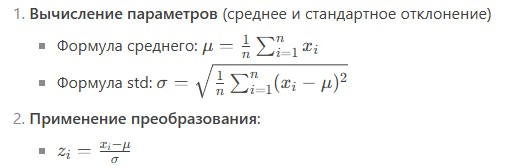

Результат выполнения:
distances_scaled - нормализованные значения формы (n_samples, 1).

In [73]:
# 1. Инициализация StandardScaler
scaler = StandardScaler()
# 2. Преобразование данных
distances_scaled = scaler.fit_transform(results_df[['Distance']])

1. Кластеризация методом DBSCAN при eps=0.5, min_samples=2.

Следующий фрагмент кода выполняет кластеризацию маршрутов по степени отклонения от эталона для:
- автоматического выявления групп схожих маршрутов;
- обнаружения аномальных траекторий (потенциальных нарушений);
- оптимизации таможенного контроля через приоритезацию проверок.

1. Инициализация DBSCAN
eps=0.5. Радиус поиска соседей в нормализованных единицах. Пример: При std=500 м, 0.5 ≈ 250 реальных метров.
min_samples=2. Минимальное количество точек для формирования кластера. Чем меньше, тем более чувствителен к шуму.

2. Выполнение кластеризации
Входные данные: distances_scaled — нормализованные отклонения (N, 1).
Процесс работы:
1) Для каждой точки ищутся соседи в радиусе eps.
2) Формируются кластеры из достижимых ядерных точек.
3) Недостижимые точки помечаются как шум (-1).
Возвращаемое значение: Массив меток кластеров вида [0, 1, -1, 0, ...].


In [103]:
# 1. Инициализация DBSCAN
# Подбираем параметры:
# eps - максимальное расстояние между соседями
# min_samples - минимальное количество соседей для ядра
dbscan_1 = DBSCAN(eps=0.5, min_samples=2)
# 2. Выполнение кластеризации
clusters_1 = dbscan_1.fit_predict(distances_scaled)


Код выполняет финальную обработку результатов кластеризации для:
- структурирования и визуализации группировки маршрутов;
- статистического анализа характеристик кластеров;
- подготовки данных для принятия решений в таможенном контроле.

Входные данные:
- results_df. Исходная таблица с колонкой 'Distance';
- clusters. Массив меток кластеров от DBSCAN.

1. Добавление меток кластеров в DataFrame
Добавляет новый столбец Cluster к существующему DataFrame.

2. Группировка и агрегация статистик
- groupby('Cluster'). Группирует данные по меткам кластеров;
- ['Distance']. Выбирает столбец с отклонениями для анализа.

Агрегатные функции:
- mean. Среднее отклонение в кластере;
- count. Количество маршрутов в кластере;
- std. Стандартное отклонение (мера разброса).


In [104]:
# 1. Добавление меток кластеров в DataFrame
results_df_1['Cluster'] = clusters_1

# 2. Группировка и агрегация статистик
cluster_stats_1 = results_df_1.groupby('Cluster')['Distance'].agg(['mean', 'count', 'std'])
print("\nСтатистика по кластерам:")
print(cluster_stats_1)



Статистика по кластерам:
                 mean  count          std
Cluster                                  
-1       23705.154042      2  9548.828202
 0        4846.753369     14  3313.316656


Так как от изменения ключевых параметров метода DBSCAN изменяется результат и точность кластеризации, необходимо проанализировать при каких параметрах достигается наибольшая точность в распределении кластеров.

2. Кластеризация методом DBSCAN при eps=0.3, min_samples=2.
При изменении eps уменьшается радиус поиска и должны формироваться более мелкие кластеры.

Результат выполнения:
Сформировано два крупных кластера (без изменений).

In [83]:
# 1. Инициализация DBSCAN
# Подбираем параметры:
# eps - максимальное расстояние между соседями
# min_samples - минимальное количество соседей для ядра
dbscan_2 = DBSCAN(eps=0.3, min_samples=2)
# 2. Выполнение кластеризации
clusters_2 = dbscan_2.fit_predict(distances_scaled)

# Добавляем кластеры в DataFrame
results_df_2['Cluster'] = clusters_2

# Анализируем кластеры
cluster_stats_2 = results_df_2.groupby('Cluster')['Distance'].agg(['mean', 'count', 'std'])
print("\nСтатистика по кластерам:")
print(cluster_stats_2)


Статистика по кластерам:
                 mean  count          std
Cluster                                  
-1       23705.154042      2  9548.828202
 0        4846.753369     14  3313.316656


3. Кластеризация методом DBSCAN при eps=0.2, min_samples=2.
При изменении eps уменьшается радиус поиска и должны формироваться более мелкие кластеры.

Результат выполнения:
Сформировано 5 более точных и мелких кластеров. 

In [84]:
dbscan_3 = DBSCAN(eps=0.2, min_samples=2)
clusters_3 = dbscan_3.fit_predict(distances_scaled)

results_df_3['Cluster'] = clusters_3

cluster_stats_3 = results_df_3.groupby('Cluster')['Distance'].agg(['mean', 'count', 'std'])
print("\nСтатистика по кластерам:")
print(cluster_stats_3)


Статистика по кластерам:
                 mean  count          std
Cluster                                  
-1       23705.154042      2  9548.828202
 0        6067.053243      5   669.202387
 1        2705.586661      3   672.757759
 2        9328.474473      3   759.701649
 3         472.365851      3    25.823315


4. Кластеризация методом DBSCAN при eps=0.5, min_samples=1.
eps остаётся без изменений, тогда как уменьшается min_samples, что снижает требования к плотности. 
Сформируется больше кластеров-одиночек.

Результат выполнения:
Сформировано 3 устойчивых кластера. 

In [85]:
dbscan_4 = DBSCAN(eps=0.5, min_samples=1)
clusters_4 = dbscan_4.fit_predict(distances_scaled)

results_df_4['Cluster'] = clusters_4

cluster_stats_4 = results_df_4.groupby('Cluster')['Distance'].agg(['mean', 'count', 'std'])
print("\nСтатистика по кластерам:")
print(cluster_stats_4)


Статистика по кластерам:
                 mean  count          std
Cluster                                  
0         4846.753369     14  3313.316656
1        16953.112868      1          NaN
2        30457.195217      1          NaN


5. Кластеризация методом DBSCAN при eps=0.3, min_samples=1.
eps уменьшается до 0.3,  min_samples также равен 1. То есть уменьшается и радиус плостости и требования к плотности.
Сформируется больше кластеров-одиночек, а также мелких кластеров.

Результат выполнения:
Сформировано 3 кластера (также, как и в предыдущем фрагменте кода, т.е. без изменений, несмотря на снижение параметра eps). 

In [86]:
dbscan_5 = DBSCAN(eps=0.3, min_samples=1)
clusters_5 = dbscan_5.fit_predict(distances_scaled)

results_df_5['Cluster'] = clusters_5

cluster_stats_5 = results_df_5.groupby('Cluster')['Distance'].agg(['mean', 'count', 'std'])
print("\nСтатистика по кластерам:")
print(cluster_stats_5)


Статистика по кластерам:
                 mean  count          std
Cluster                                  
0         4846.753369     14  3313.316656
1        16953.112868      1          NaN
2        30457.195217      1          NaN


6. Кластеризация методом DBSCAN при eps=0.1, min_samples=1.
eps уменьшается до 0.3,  min_samples также равен 1. То есть уменьшается и радиус плостости и требования к плотности.
Сформируется больше кластеров-одиночек, а также мелких кластеров.

Результат выполнения:
При данных минимальных параметрах сформировано наибольшее количество кластеров - 9.

In [87]:
dbscan_6 = DBSCAN(eps=0.1, min_samples=1)
clusters_6 = dbscan_6.fit_predict(distances_scaled)

results_df_6['Cluster'] = clusters_6

cluster_stats_6 = results_df_6.groupby('Cluster')['Distance'].agg(['mean', 'count', 'std'])
print("\nСтатистика по кластерам:")
print(cluster_stats_6)


Статистика по кластерам:
                 mean  count         std
Cluster                                 
0         5027.429255      1         NaN
1         2319.757208      2  109.634863
2         6326.959240      4  383.103464
3         8487.196109      1         NaN
4         9749.113655      2  304.416266
5          472.365851      3   25.823315
6        16953.112868      1         NaN
7         3477.245567      1         NaN
8        30457.195217      1         NaN


#### 6.2. Визуализация сформированных кластеров при различных параметрах метода DBSCAN

##### 1) Визуализация и интерпретация результатов кластеризации DBSCAN(eps=0.5, min_samples=2)

Код создает информативную визуализацию результатов кластеризации для:
- наглядного представления группировки маршрутов по степени отклонения;
- быстрой идентификации аномальных траекторий (выбросов);
- визуальной верификации качества кластеризации.

Входные данные:
results_df - таблица с колонками: Distance, Cluster;
clusters - массив меток кластеров.

1. Инициализация графика
Создает фигуру шириной 10 дюймов и высотой 6 дюймов
Оптимальный размер для детализации при сохранении читаемости.

2. Цветовая схема
Закодированные цвета для 5 возможных кластеров
Логика выбора:
- зеленый. Нормальные маршруты;
- синий. Умеренные отклонения;
- красный. Критические отклонения;
- черный. Выбросы (специально выделены).

3. Отрисовка кластеров
np.unique(clusters) - находит все уникальные номера кластеров.
Фильтрация данных - выделяет точки текущего кластера.
Параметры визуализации:
- s=100. Размер точек для лучшей видимости;
- label. Для легенды.

4. Выделение выбросов
Проверка empty - защита от отсутствия выбросов.
Специальные маркеры:
- marker='x'. Крестики для четкого выделения;
- черный цвет. Стандартное обозначение аномалий.

5. Оформление графика
- rotation=45. Наклон подписей оси X для читаемости;
- grid=True. Сетка для точного определения значений;
- tight_layout(). Автоматическая оптимизация расположения элементов.

Результат выполнения
График рассеяния с:
- цветовой кодировкой кластеров;
- четким выделением выбросов;
- подписями и легендой.

Ключевые элементы:
- ось X. Идентификаторы маршрутов;
- ось Y. Величина отклонения в метрах;
- легенда. Соответствие цветов кластерам.


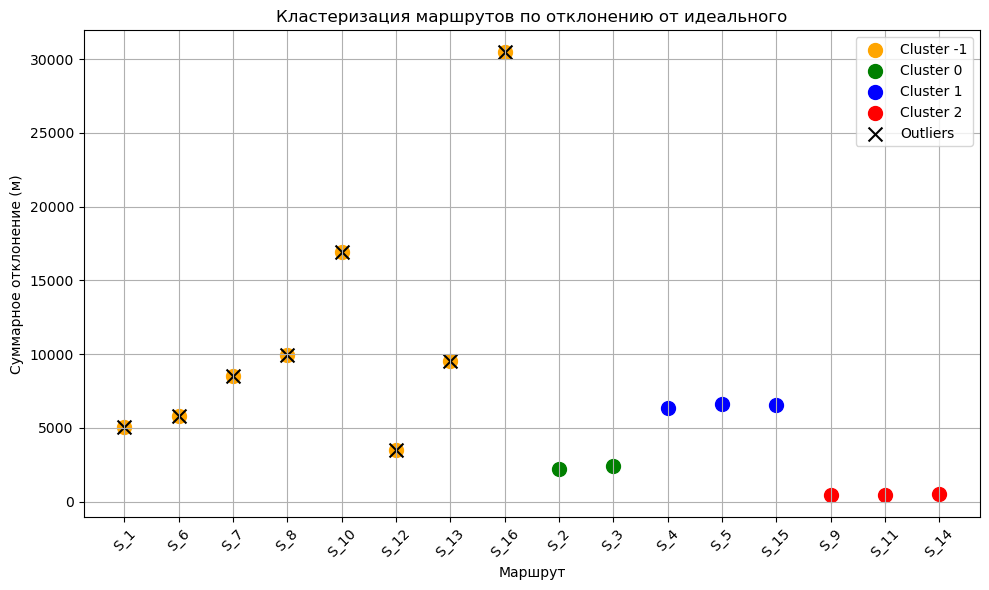

In [101]:
# 1. Инициализация графика
plt.figure(figsize=(10, 6))

# 2. Цветовая схема
colors = ['green', 'blue', 'red', 'purple', 'orange']

# 3. Отрисовка кластеров
for cluster_num in np.unique(clusters_1):
    cluster_data = results_df_1[results_df_1['Cluster'] == cluster_num]
    plt.scatter(
        cluster_data.index,
        cluster_data['Distance'],
        c=colors[cluster_num],
        label=f'Cluster {cluster_num}',
        s=100
    )

# 4. Выделение выбросов
outliers = results_df[results_df_1['Cluster'] == -1]
if not outliers.empty:
    plt.scatter(
        outliers.index,
        outliers['Distance'],
        c='black',
        label='Outliers',
        marker='x',
        s=100
    )

# 5. Оформление графика
plt.title('Кластеризация маршрутов по отклонению от идеального')
plt.xlabel('Маршрут')
plt.ylabel('Суммарное отклонение (м)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Код выполняет смысловую интерпретацию результатов кластеризации для:
- категоризации маршрутов по степени риска (хорошие/нормальные/плохие);
- формирования понятных выводов для не-технических специалистов;
- подготовки рекомендаций по дальнейшим действиям.

Входные данные:
- clusters. Массив меток кластеров;
- cluster_stats. Статистика по кластерам;
- results_df. Исходные данные с отклонениями.

1. Итерация по кластерам
- np.unique(clusters). Находит уникальные номера кластеров;
- sorted(). Гарантирует порядок от -1 до N.

2. Обработка выбросов
Специальная категория для аномалий.
Четкая маркировка проблемных случаев.

3. Классификация кластеров
Квантильная классификация:
- нижние 33%. Хорошие;
- 33-66%. Нормальные;
- верхние 33% Плохие.
Динамические пороги адаптируются к конкретным данным.

4. Вывод детализации
Показывает конкретные отклонения для каждого маршрута кластера/

Результат выполнения:
Текстовый отчет.

In [89]:
print("\nИнтерпретация кластеров:")
# 1. Итерация по кластерам
for cluster_num in sorted(np.unique(clusters_1)):
    # 2. Обработка выбросов
    if cluster_num == -1:
        print("Выбросы (очень плохие маршруты):")
    # 3. Классификация кластеров
    else:
        mean_dist = cluster_stats_1.loc[cluster_num, 'mean']
        if mean_dist < cluster_stats_1['mean'].quantile(0.33):
            print(f"Кластер {cluster_num}: Хорошие маршруты (среднее отклонение: {mean_dist:.2f} м)")
        elif mean_dist < cluster_stats_1['mean'].quantile(0.66):
            print(f"Кластер {cluster_num}: Нормальные маршруты (среднее отклонение: {mean_dist:.2f} м)")
        else:
            print(f"Кластер {cluster_num}: Плохие маршруты (среднее отклонение: {mean_dist:.2f} м)")
    
    # 4. Вывод детализации
    print(results_df_1[results_df_1['Cluster'] == cluster_num][['Distance']])
    print()


Интерпретация кластеров:
Выбросы (очень плохие маршруты):
          Distance
S_1    5027.429255
S_2    2242.233653
S_3    2397.280763
S_4    6331.001503
S_5    6620.636742
S_6    5784.574613
S_7    8487.196109
S_8    9964.368461
S_10  16953.112868
S_12   3477.245567
S_13   9533.858849
S_15   6571.624103
S_16  30457.195217

Кластер 0: Хорошие маршруты (среднее отклонение: 472.37 м)
        Distance
S_9   444.956423
S_11  475.902675
S_14  496.238457



##### 2) Визуализация и интерпретация результатов кластеризации DBSCAN(eps=0.3, min_samples=2)

Код создает информативную визуализацию результатов кластеризации DBSCAN с параметрами eps=0.3, min_samples=2.
Наглядно видно 2 выделенных кластера, два маршрута попали в "выбросы", все остальные определены как достаточно хорошие маршруты. 
Отсюда можно сделать вывод, что метод кластеризации с такими параметрами имеет дотстаточно небольшую точность и выделяет всего два два крупных кластера.

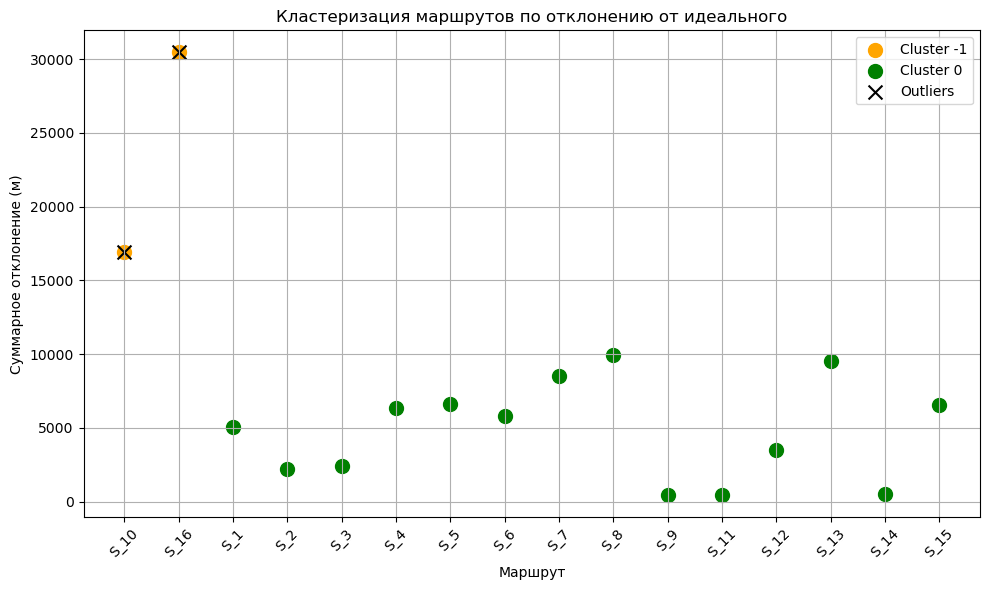


Интерпретация кластеров:
Выбросы (очень плохие маршруты):
          Distance
S_10  16953.112868
S_16  30457.195217

Кластер 0: Хорошие маршруты (среднее отклонение: 4846.75 м)
         Distance
S_1   5027.429255
S_2   2242.233653
S_3   2397.280763
S_4   6331.001503
S_5   6620.636742
S_6   5784.574613
S_7   8487.196109
S_8   9964.368461
S_9    444.956423
S_11   475.902675
S_12  3477.245567
S_13  9533.858849
S_14   496.238457
S_15  6571.624103



In [90]:
# 1. Инициализация графика
plt.figure(figsize=(10, 6))

# 2. Цветовая схема
colors = ['green', 'blue', 'red', 'purple', 'orange']

# 3. Отрисовка кластеров
for cluster_num in np.unique(clusters_2):
    cluster_data = results_df_2[results_df_2['Cluster'] == cluster_num]
    plt.scatter(
        cluster_data.index,
        cluster_data['Distance'],
        c=colors[cluster_num],
        label=f'Cluster {cluster_num}',
        s=100
    )

# 4. Выделение выбросов
outliers = results_df_2[results_df_2['Cluster'] == -1]
if not outliers.empty:
    plt.scatter(
        outliers.index,
        outliers['Distance'],
        c='black',
        label='Outliers',
        marker='x',
        s=100
    )

# 5. Оформление графика
plt.title('Кластеризация маршрутов по отклонению от идеального')
plt.xlabel('Маршрут')
plt.ylabel('Суммарное отклонение (м)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nИнтерпретация кластеров:")
# 1. Итерация по кластерам
for cluster_num in sorted(np.unique(clusters_2)):
    # 2. Обработка выбросов
    if cluster_num == -1:
        print("Выбросы (очень плохие маршруты):")
    # 3. Классификация кластеров
    else:
        mean_dist = cluster_stats_2.loc[cluster_num, 'mean']
        if mean_dist < cluster_stats_2['mean'].quantile(0.33):
            print(f"Кластер {cluster_num}: Хорошие маршруты (среднее отклонение: {mean_dist:.2f} м)")
        elif mean_dist < cluster_stats_2['mean'].quantile(0.66):
            print(f"Кластер {cluster_num}: Нормальные маршруты (среднее отклонение: {mean_dist:.2f} м)")
        else:
            print(f"Кластер {cluster_num}: Плохие маршруты (среднее отклонение: {mean_dist:.2f} м)")
    
    # 4. Вывод детализации
    print(results_df_2[results_df_2['Cluster'] == cluster_num][['Distance']])
    print()

##### 3) Визуализация и интерпретация результатов кластеризации DBSCAN(eps=0.2, min_samples=2)

Код создает информативную визуализацию результатов кластеризации DBSCAN с параметрами eps=0.2, min_samples=2.
Здесь для наглядности определения кластеров используются 5 цветов:
- оранжевый (Cluster -1). Определяет выбросы, которые дополнительно на графике помечаются маркером;
- зелёный (Cluster 0). Нормальные маршруты, имеющие среднее отклонение около 6067.05 м;
- синий (Cluster 1). Хорошие маршруты (среднее отклонение: 2705.59 м);
- красный (Cluster 2). Плохие маршруты, среднее отклонение которых превышает норму и составляет ~9328.47 м;
- пурпурный (Cluster 3). Наилучшие варианты маршрутов (среднее отклонение: 472.37 м).
Наглядно видно 5 выделенных кластеров, два маршрута также попали в "выбросы", как и в при предыдущих параметрах eps=0.5 и eps=0.3.
3 маршрута (7-ой, 8-ой и 13-ый) были отнесены к "плохим".
Остальные определены как нормальные и хорошие.

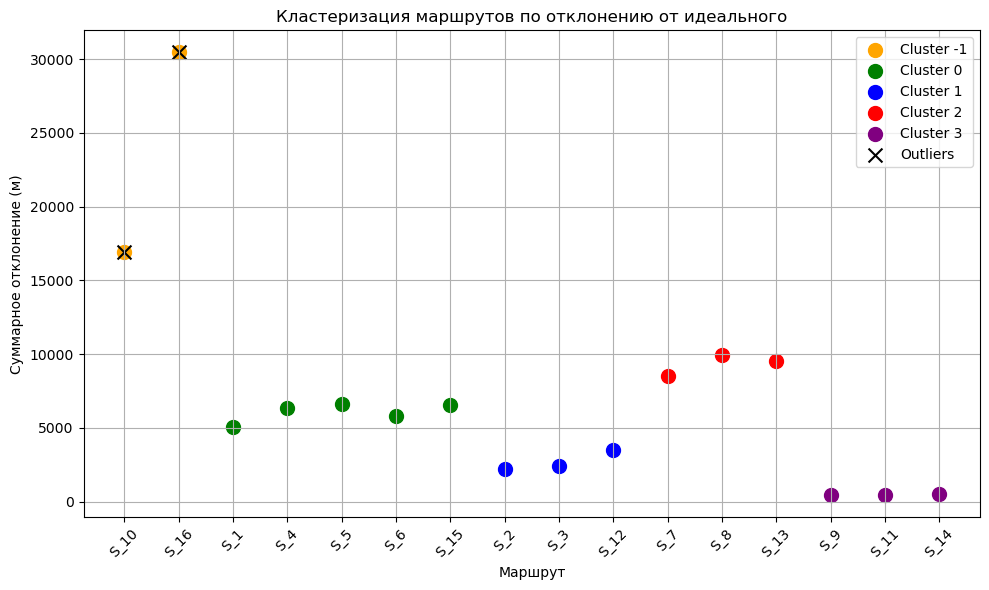


Интерпретация кластеров:
Выбросы (очень плохие маршруты):
          Distance
S_10  16953.112868
S_16  30457.195217

Кластер 0: Нормальные маршруты (среднее отклонение: 6067.05 м)
         Distance
S_1   5027.429255
S_4   6331.001503
S_5   6620.636742
S_6   5784.574613
S_15  6571.624103

Кластер 1: Хорошие маршруты (среднее отклонение: 2705.59 м)
         Distance
S_2   2242.233653
S_3   2397.280763
S_12  3477.245567

Кластер 2: Плохие маршруты (среднее отклонение: 9328.47 м)
         Distance
S_7   8487.196109
S_8   9964.368461
S_13  9533.858849

Кластер 3: Хорошие маршруты (среднее отклонение: 472.37 м)
        Distance
S_9   444.956423
S_11  475.902675
S_14  496.238457



In [91]:
# 1. Инициализация графика
plt.figure(figsize=(10, 6))

# 2. Цветовая схема
colors = ['green', 'blue', 'red', 'purple', 'orange']

# 3. Отрисовка кластеров
for cluster_num in np.unique(clusters_3):
    cluster_data = results_df_3[results_df_3['Cluster'] == cluster_num]
    plt.scatter(
        cluster_data.index,
        cluster_data['Distance'],
        c=colors[cluster_num],
        label=f'Cluster {cluster_num}',
        s=100
    )

# 4. Выделение выбросов
outliers = results_df_3[results_df_3['Cluster'] == -1]
if not outliers.empty:
    plt.scatter(
        outliers.index,
        outliers['Distance'],
        c='black',
        label='Outliers',
        marker='x',
        s=100
    )

# 5. Оформление графика
plt.title('Кластеризация маршрутов по отклонению от идеального')
plt.xlabel('Маршрут')
plt.ylabel('Суммарное отклонение (м)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nИнтерпретация кластеров:")
# 1. Итерация по кластерам
for cluster_num in sorted(np.unique(clusters_3)):
    # 2. Обработка выбросов
    if cluster_num == -1:
        print("Выбросы (очень плохие маршруты):")
    # 3. Классификация кластеров
    else:
        mean_dist = cluster_stats_3.loc[cluster_num, 'mean']
        if mean_dist < cluster_stats_3['mean'].quantile(0.33):
            print(f"Кластер {cluster_num}: Хорошие маршруты (среднее отклонение: {mean_dist:.2f} м)")
        elif mean_dist < cluster_stats_3['mean'].quantile(0.66):
            print(f"Кластер {cluster_num}: Нормальные маршруты (среднее отклонение: {mean_dist:.2f} м)")
        else:
            print(f"Кластер {cluster_num}: Плохие маршруты (среднее отклонение: {mean_dist:.2f} м)")
    
    # 4. Вывод детализации
    print(results_df_3[results_df_3['Cluster'] == cluster_num][['Distance']])
    print()

##### 4) Визуализация и интерпретация результатов кластеризации DBSCAN(eps=0.5, min_samples=1)

Код создает  визуализацию результатов кластеризации DBSCAN с параметрами eps=0.5, min_samples=1.
Здесь для наглядности определения кластеров используются 3 цвета:
- зелёный (Cluster 0). Нормальные маршруты, имеющие среднее отклонение около 6067.05 м;
- синий (Cluster 1). Хорошие маршруты (среднее отклонение: 2705.59 м);
- красный (Cluster 2). Плохие маршруты, среднее отклонение которых превышает норму и составляет ~9328.47 м;

Наглядно видно 3 выделенных кластера, ни один маршрут при таких параметрах не был определён как "выброс".
Большинство маршрутов отнесены к первому кластеру, т.е. к "хорошим маршрутам".
Маршрут 10 - "нормальный", и 16 - "плохой" (следует отметить, что и в предыдущих фрагментах кодов с изменяемыми параметрами eps 16-ый маршрут определялся как "выбор" или "очень плохой"). 

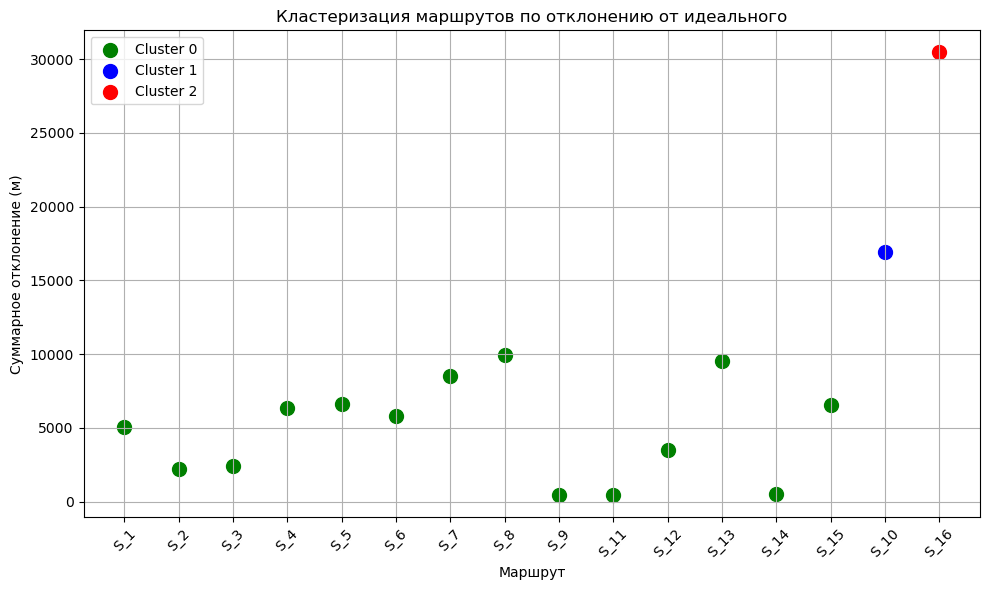


Интерпретация кластеров:
Кластер 0: Хорошие маршруты (среднее отклонение: 4846.75 м)
         Distance
S_1   5027.429255
S_2   2242.233653
S_3   2397.280763
S_4   6331.001503
S_5   6620.636742
S_6   5784.574613
S_7   8487.196109
S_8   9964.368461
S_9    444.956423
S_11   475.902675
S_12  3477.245567
S_13  9533.858849
S_14   496.238457
S_15  6571.624103

Кластер 1: Нормальные маршруты (среднее отклонение: 16953.11 м)
          Distance
S_10  16953.112868

Кластер 2: Плохие маршруты (среднее отклонение: 30457.20 м)
          Distance
S_16  30457.195217



In [92]:
# 1. Инициализация графика
plt.figure(figsize=(10, 6))

# 2. Цветовая схема
colors = ['green', 'blue', 'red', 'purple', 'orange']

# 3. Отрисовка кластеров
for cluster_num in np.unique(clusters_4):
    cluster_data = results_df_4[results_df_4['Cluster'] == cluster_num]
    plt.scatter(
        cluster_data.index,
        cluster_data['Distance'],
        c=colors[cluster_num],
        label=f'Cluster {cluster_num}',
        s=100
    )

# 4. Выделение выбросов
outliers = results_df_4[results_df_4['Cluster'] == -1]
if not outliers.empty:
    plt.scatter(
        outliers.index,
        outliers['Distance'],
        c='black',
        label='Outliers',
        marker='x',
        s=100
    )

# 5. Оформление графика
plt.title('Кластеризация маршрутов по отклонению от идеального')
plt.xlabel('Маршрут')
plt.ylabel('Суммарное отклонение (м)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nИнтерпретация кластеров:")
# 1. Итерация по кластерам
for cluster_num in sorted(np.unique(clusters_4)):
    # 2. Обработка выбросов
    if cluster_num == -1:
        print("Выбросы (очень плохие маршруты):")
    # 3. Классификация кластеров
    else:
        mean_dist = cluster_stats_4.loc[cluster_num, 'mean']
        if mean_dist < cluster_stats_4['mean'].quantile(0.33):
            print(f"Кластер {cluster_num}: Хорошие маршруты (среднее отклонение: {mean_dist:.2f} м)")
        elif mean_dist < cluster_stats_4['mean'].quantile(0.66):
            print(f"Кластер {cluster_num}: Нормальные маршруты (среднее отклонение: {mean_dist:.2f} м)")
        else:
            print(f"Кластер {cluster_num}: Плохие маршруты (среднее отклонение: {mean_dist:.2f} м)")
    
    # 4. Вывод детализации
    print(results_df_4[results_df_4['Cluster'] == cluster_num][['Distance']])
    print()

##### 5) Визуализация и интерпретация результатов кластеризации DBSCAN(eps=0.3, min_samples=1)

Код создает  визуализацию результатов кластеризации DBSCAN с параметрами eps=0.3, min_samples=1.
Для  определения кластеров используются 3 цвета:
- зелёный (Cluster 0). Нормальные маршруты, имеющие среднее отклонение около 6067.05 м;
- синий (Cluster 1). Хорошие маршруты (среднее отклонение: 2705.59 м);
- красный (Cluster 2). Плохие маршруты, среднее отклонение которых превышает норму и составляет ~9328.47 м;
Таким образом, при изменении параметра на eps с eps=0.5 до eps=0.3 и статическом min_samples=1 не произошло изменений в результатах кластеризации, также определены 3 основных кластера: хорошие, нормальные и плохие маршруты.

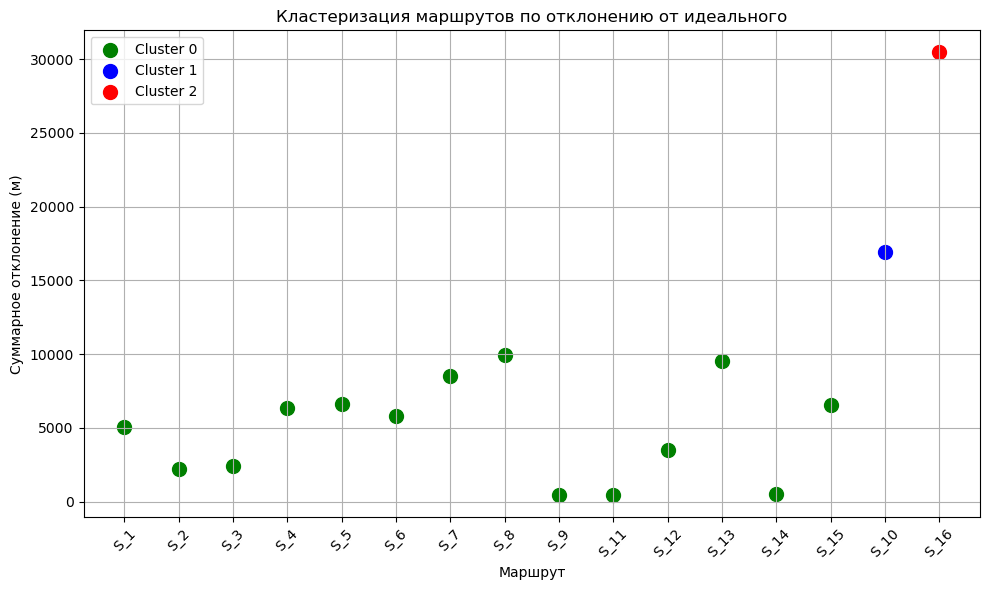


Интерпретация кластеров:
Кластер 0: Хорошие маршруты (среднее отклонение: 4846.75 м)
         Distance
S_1   5027.429255
S_2   2242.233653
S_3   2397.280763
S_4   6331.001503
S_5   6620.636742
S_6   5784.574613
S_7   8487.196109
S_8   9964.368461
S_9    444.956423
S_11   475.902675
S_12  3477.245567
S_13  9533.858849
S_14   496.238457
S_15  6571.624103

Кластер 1: Нормальные маршруты (среднее отклонение: 16953.11 м)
          Distance
S_10  16953.112868

Кластер 2: Плохие маршруты (среднее отклонение: 30457.20 м)
          Distance
S_16  30457.195217



In [93]:
# 1. Инициализация графика
plt.figure(figsize=(10, 6))

# 2. Цветовая схема
colors = ['green', 'blue', 'red', 'purple', 'orange']

# 3. Отрисовка кластеров
for cluster_num in np.unique(clusters_5):
    cluster_data = results_df_5[results_df_5['Cluster'] == cluster_num]
    plt.scatter(
        cluster_data.index,
        cluster_data['Distance'],
        c=colors[cluster_num],
        label=f'Cluster {cluster_num}',
        s=100
    )

# 4. Выделение выбросов
outliers = results_df_5[results_df_5['Cluster'] == -1]
if not outliers.empty:
    plt.scatter(
        outliers.index,
        outliers['Distance'],
        c='black',
        label='Outliers',
        marker='x',
        s=100
    )

# 5. Оформление графика
plt.title('Кластеризация маршрутов по отклонению от идеального')
plt.xlabel('Маршрут')
plt.ylabel('Суммарное отклонение (м)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nИнтерпретация кластеров:")
# 1. Итерация по кластерам
for cluster_num in sorted(np.unique(clusters_5)):
    # 2. Обработка выбросов
    if cluster_num == -1:
        print("Выбросы (очень плохие маршруты):")
    # 3. Классификация кластеров
    else:
        mean_dist = cluster_stats_5.loc[cluster_num, 'mean']
        if mean_dist < cluster_stats_5['mean'].quantile(0.33):
            print(f"Кластер {cluster_num}: Хорошие маршруты (среднее отклонение: {mean_dist:.2f} м)")
        elif mean_dist < cluster_stats_5['mean'].quantile(0.66):
            print(f"Кластер {cluster_num}: Нормальные маршруты (среднее отклонение: {mean_dist:.2f} м)")
        else:
            print(f"Кластер {cluster_num}: Плохие маршруты (среднее отклонение: {mean_dist:.2f} м)")
    
    # 4. Вывод детализации
    print(results_df_5[results_df_5['Cluster'] == cluster_num][['Distance']])
    print()

##### 6) Визуализация и интерпретация результатов кластеризации DBSCAN(eps=0.1, min_samples=1)

Данный код предназначен для визуализации и классификации маршрутов на основе их отклонений от эталонных значений с использованием кластеризации DBSCAN. Основные задачи:
- визуальное представление кластеров маршрутов с цветовой кодировкой по степени отклонения;
- подробная статистическая характеристика каждого кластера;
- категоризация маршрутов по качеству на основе квантилей распределения отклонений.

1. Инициализация графика
Создается фигура для построения графика с увеличенным размером 14x8 дюймов.
Увеличенный размер позволяет лучше отобразить множество маршрутов и сделать график более читаемым.

2. Расширенная цветовая схема с градацией качества
Создается словарь, где ключи - номера кластеров, а значения - кортежи из:
Цвета для визуализации (например, 'lime', 'green')
- маркера точки ('o' - круг, 'X' - крест, 'D' - ромб);
- текстового описания категории.
Цвета подобраны по градиенту от хороших (зеленые) к плохим (красные)
Особые случаи:
- кластер -1 (выбросы) выделены черным цветом и крестом;
- специальные маршруты (кластер 8) обозначены ромбами фиолетового цвета.

3. Отрисовка кластеров
Для каждого уникального номера кластера:
а) проверяется наличие в цветовой схеме (пропускаем неопределенные);
б) извлекаются параметры визуализации (цвет, маркер, подпись);
в) фильтруются данные маршрутов текущего кластера;
г) создается scatter plot (точечная диаграмма) с параметрами:
- по X - индекс маршрута;
- по Y - величина отклонения (Distance);
- цвет и маркер из цветовой схемы;
- размер точек: 120 для выбросов (выделение), 100 для остальных;
- подпись в легенде с названием категории и номером кластера;
- прозрачность 0.8 для лучшего восприятия перекрывающихся точек;
- черная граница точек толщиной 0.5 для контраста.

4. Оформление графика
Заголовок графика с указанием метода кластеризации (DBSCAN) и параметров
Подписи осей с единицами измерения
Наклон подписей по X на 45 градусов для лучшей читаемости
Сетка с пунктирными линиями и прозрачностью 0.4
Легенда:
- с заголовком "Категории маршрутов";
- расположена справа от графика (bbox_to_anchor);
- использует шрифт размера 10;
- tight_layout() автоматически adjusts subplot params для предотвращения overlap;
- show() отображает график.

5. Интерпретация кластеров
Вычисляются квантили (0.1, 0.3, 0.5, 0.7, 0.9) средних отклонений кластеров.
Используются для более точной классификации качества маршрутов.
Для каждого кластера (включая выбросы -1) выводится подробная информация:
а) для выбросов - специальный заголовок
б) для остальных кластеров:
- рассчитывается категория на основе квантилей;
- формируется текстовое описание качества;
- выводится статистика: среднее отклонение, стандартное отклонение, количество маршрутов.
Для каждого кластера отображается таблица маршрутов с цветовым градиентом:
- для нормальных кластеров используется инвертированная красно-желто-зеленая палитра (RdYlGn_r);
- для выбросов - красная палитра (Reds);
- таблица снабжается заголовком с номером кластера;

Код создает  визуализацию результатов кластеризации DBSCAN с параметрами eps=0.1, min_samples=1.
Улучшена цветовая схема и обозначение кластеров, так как их количество значительно.

Здесь используется наибольшее количество цветов для определения всех кластеров:
- чёрный (Cluster -1). Определяет выбросы;
- лаймовый (Cluster 0). Очень хорошие маршруты;
- зелёный (Cluster 1). Хорошие маршруты;
- аквамариновый (Cluster 2). Удовлетворительные маршруты, но недостаточно хорошие;
- голубой (Cluster 3). Средние или достаточно нормальные маршруты;
- золотой (Cluster 4). Приемлимые;
- оранжевый (Cluster 5). Плохие или проблемные маршруты;
- красный (Cluster 6).  Очень плохие;
- тёмно-красный (Cluster 7). Критические отклонения в маршруте;
- пурпурный (Cluster 8). Специальные.


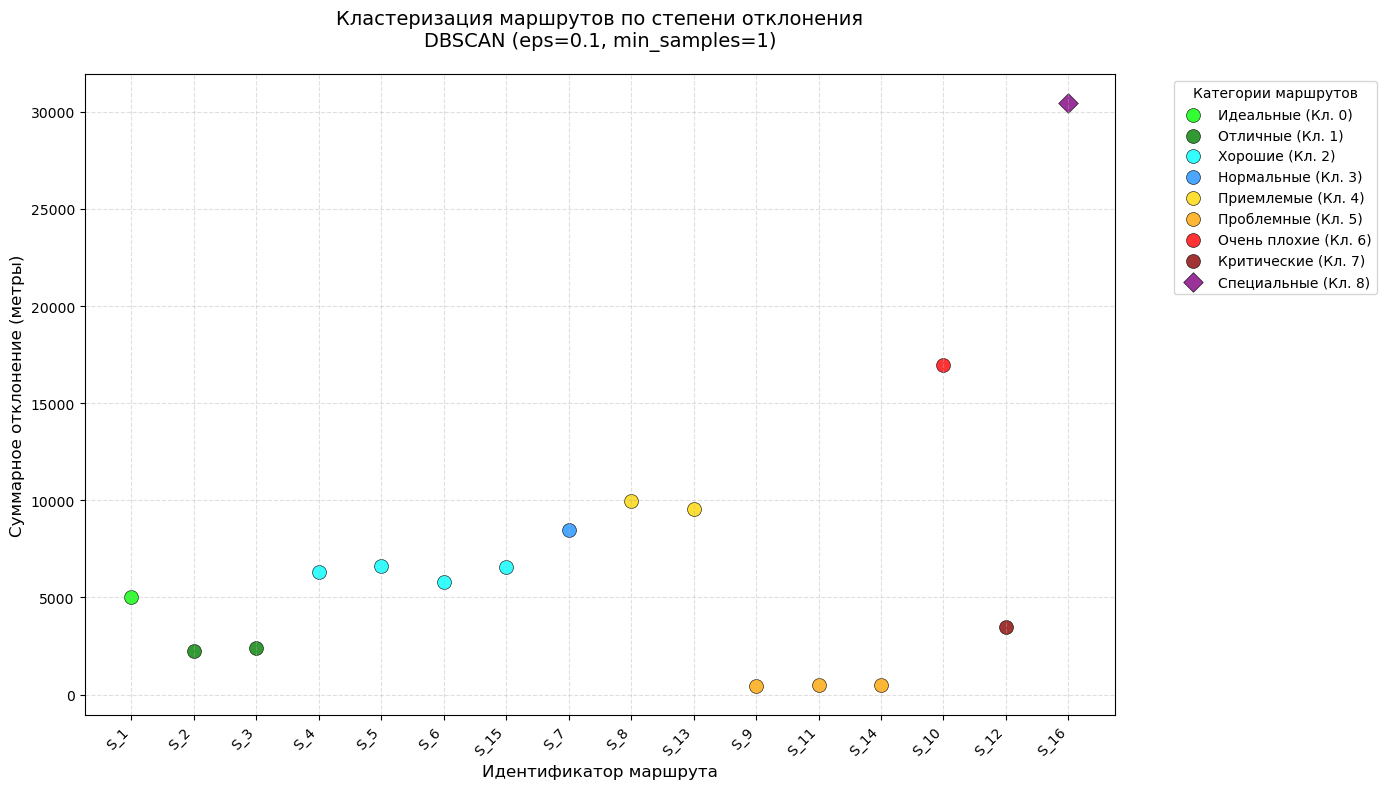


Детальная кластеризация маршрутов:

=== КЛАСТЕР 0: ХОРОШИЕ ===
Среднее отклонение: 5027.43 м (±nan м)
Количество маршрутов: 1
Характеристика: Допустимые отклонения


,Distance,Cluster
S_1,5027.429255,0



=== КЛАСТЕР 1: ОТЛИЧНЫЕ ===
Среднее отклонение: 2319.76 м (±109.63 м)
Количество маршрутов: 2
Характеристика: Незначительные отклонения


,Distance,Cluster
S_2,2242.233653,1
S_3,2397.280763,1



=== КЛАСТЕР 2: СРЕДНИЕ ===
Среднее отклонение: 6326.96 м (±383.10 м)
Количество маршрутов: 4
Характеристика: Заметные отклонения, требуют проверки


,Distance,Cluster
S_4,6331.001503,2
S_5,6620.636742,2
S_6,5784.574613,2
S_15,6571.624103,2



=== КЛАСТЕР 3: СРЕДНИЕ ===
Среднее отклонение: 8487.20 м (±nan м)
Количество маршрутов: 1
Характеристика: Заметные отклонения, требуют проверки


,Distance,Cluster
S_7,8487.196109,3



=== КЛАСТЕР 4: ПРОБЛЕМНЫЕ ===
Среднее отклонение: 9749.11 м (±304.42 м)
Количество маршрутов: 2
Характеристика: Существенные отклонения


,Distance,Cluster
S_8,9964.368461,4
S_13,9533.858849,4



=== КЛАСТЕР 5: ИДЕАЛЬНЫЕ ===
Среднее отклонение: 472.37 м (±25.82 м)
Количество маршрутов: 3
Характеристика: Практически полное соответствие эталону


,Distance,Cluster
S_9,444.956423,5
S_11,475.902675,5
S_14,496.238457,5



=== КЛАСТЕР 6: ПРОБЛЕМНЫЕ ===
Среднее отклонение: 16953.11 м (±nan м)
Количество маршрутов: 1
Характеристика: Существенные отклонения


,Distance,Cluster
S_10,16953.112868,6



=== КЛАСТЕР 7: ОТЛИЧНЫЕ ===
Среднее отклонение: 3477.25 м (±nan м)
Количество маршрутов: 1
Характеристика: Незначительные отклонения


,Distance,Cluster
S_12,3477.245567,7



=== КЛАСТЕР 8: КРИТИЧЕСКИЕ ===
Среднее отклонение: 30457.20 м (±nan м)
Количество маршрутов: 1
Характеристика: Недопустимые отклонения


,Distance,Cluster
S_16,30457.195217,8


In [94]:
# 1. Инициализация графика с увеличенным размером
plt.figure(figsize=(14, 8))

# 2. Расширенная цветовая схема с градацией качества
cluster_colors = {
    -1: ('black', 'X', 'Критические отклонения'),    # Выбросы
    0: ('lime', 'o', 'Идеальные'),                  # Очень хорошие
    1: ('green', 'o', 'Отличные'),                  # Хорошие
    2: ('aqua', 'o', 'Хорошие'),                    # Удовлетворительные
    3: ('dodgerblue', 'o', 'Нормальные'),           # Средние
    4: ('gold', 'o', 'Приемлемые'),                 # Приемлемые
    5: ('orange', 'o', 'Проблемные'),               # Плохие
    6: ('red', 'o', 'Очень плохие'),                # Очень плохие
    7: ('darkred', 'o', 'Критические'),             # Критические
    8: ('purple', 'D', 'Специальные')               # Особые случаи
}

# 3. Отрисовка кластеров
for cluster_num in np.unique(clusters_6):
    if cluster_num not in cluster_colors:
        continue  # Пропускаем неопределенные кластеры
        
    color, marker, label = cluster_colors[cluster_num]
    cluster_data = results_df_6[results_df_6['Cluster'] == cluster_num]
    
    plt.scatter(
        cluster_data.index,
        cluster_data['Distance'],
        c=color,
        marker=marker,
        s=120 if cluster_num == -1 else 100,
        label=f'{label} (Кл. {cluster_num})',
        alpha=0.8,
        edgecolors='black',
        linewidths=0.5
    )

# 4. Оформление графика
plt.title('Кластеризация маршрутов по степени отклонения\nDBSCAN (eps=0.1, min_samples=1)', 
          fontsize=14, pad=20)
plt.xlabel('Идентификатор маршрута', fontsize=12)
plt.ylabel('Суммарное отклонение (метры)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)

# Улучшенная легенда
plt.legend(title="Категории маршрутов", bbox_to_anchor=(1.05, 1), 
           loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# 5. Интерпретация кластеров
print("\nДетальная кластеризация маршрутов:")

# Определяем квантили для более точной классификации
quantiles = cluster_stats_6['mean'].quantile([0.1, 0.3, 0.5, 0.7, 0.9])

for cluster_num in sorted(np.unique(clusters_6)):
    if cluster_num == -1:
        print("\n=== КРИТИЧЕСКИЕ ОТКЛОНЕНИЯ (ВЫБРОСЫ) ===")
    else:
        mean_dist = cluster_stats_6.loc[cluster_num, 'mean']
        std_dist = cluster_stats_6.loc[cluster_num, 'std']
        count = cluster_stats_6.loc[cluster_num, 'count']
        
        # Расширенная классификация по квантилям
        if mean_dist < quantiles[0.1]:
            category = "ИДЕАЛЬНЫЕ"
            description = "Практически полное соответствие эталону"
        elif mean_dist < quantiles[0.3]:
            category = "ОТЛИЧНЫЕ"
            description = "Незначительные отклонения"
        elif mean_dist < quantiles[0.5]:
            category = "ХОРОШИЕ"
            description = "Допустимые отклонения"
        elif mean_dist < quantiles[0.7]:
            category = "СРЕДНИЕ"
            description = "Заметные отклонения, требуют проверки"
        elif mean_dist < quantiles[0.9]:
            category = "ПРОБЛЕМНЫЕ"
            description = "Существенные отклонения"
        else:
            category = "КРИТИЧЕСКИЕ"
            description = "Недопустимые отклонения"
        
        print(f"\n=== КЛАСТЕР {cluster_num}: {category} ===")
        print(f"Среднее отклонение: {mean_dist:.2f} м (±{std_dist:.2f} м)")
        print(f"Количество маршрутов: {count}")
        print(f"Характеристика: {description}")
    
    # Вывод таблицы маршрутов с цветовым кодированием
    display(results_df_6[results_df_6['Cluster'] == cluster_num]
           .style
           .background_gradient(subset=['Distance'], 
                               cmap='RdYlGn_r' if cluster_num != -1 else 'Reds')
           .set_caption(f"Маршруты кластера {cluster_num}"))


### 7. Оценка точности кластеризации DBSCAN

#### 7.1. Метрики оценки качества кластеризации

Для оценки качества кластеризации используются три основные метрики: 
1) Silhouette Score (Коэффициент силуэта);
2) Calinski-Harabasz Index (Индекс Калински-Харабаша или критерий коэффициента дисперсии);
3) Davies-Bouldin Index (DBI или Индекс Дэвиса-Болдина);
Эти метрики позволяют оценить, насколько хорошо алгоритм кластеризации (в данном случае DBSCAN) разделил данные на группы.

1) Silhouette Score (Коэффициент силуэта)

Коэффициент силуэта в кластеризации — это величина, которая позволяет оценить степень соответствия построенной кластерной структуры обучающим данным, т.е. оценить качество кластеризации.
Иными словами, коэффициент силуэта показывает, насколько каждый объект «похож» на другие объекты в том кластере, в который он был распределен в процессе кластеризации, и «не похож» на объекты из других кластеров.
Метод был предложен бельгийским статистиком Питером Руссо в 1987 году.
В основе идеи метода лежит вычисление коэффициентов, которые присваиваются каждому объекту в кластере и образуют так называемый силуэт кластера.
Коэффициенты изменяются от -1 до 1.
Значения, близкие к 1, указывают на то, что объект является похожим на другие объекты в кластере и не похожим на объекты из других кластеров.
Если большинство объектов имеют значения коэффициентов близкими к 1, можно утверждать, что кластерная структура хорошо выражена, и количество кластеров соответствует естественной группировке данных.


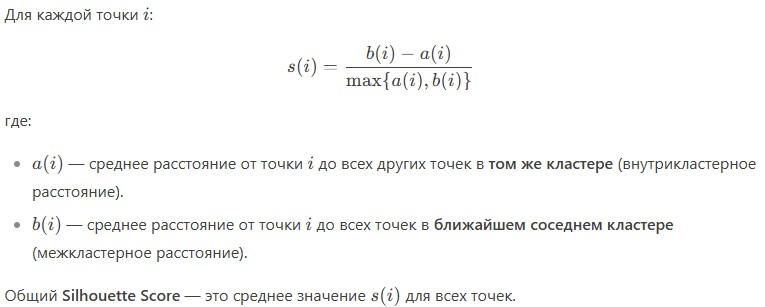

Диапазон значений: от -1 до 1.
s(i)≈1. Кластеризация отличная. Точка находится далеко от других кластеров.
s(i)≈0. Кластеры пересекаются или точки находятся на границе.
s(i)≈-1. Точка ошибочно отнесена к другому кластеру.

На рисунке схематично представлены основные компоненты, используемые при вычислении коэффициента силуэта (Silhouette Score) для оценки качества кластеризации.

di - текущая точка данных, для которой вычисляется коэффициент силуэта;
b(di) - среднее расстояние от точки di до всех точек в ближайшем соседнем кластере (межкластерное расстояние). Чем больше, , тем дальше точка от соседних кластеров → кластеры хорошо разделены;
C1 - кластер, к которому принадлежит точка di;
a(di) - среднее расстояние от точки di до всех других точек в её собственном кластере C1 (внутрикластерное расстояние). Чем меньше значение, тем ближе точка к другим точкам своего кластера → кластер плотный.

Кластеризация считается идельной, если:
a(di)≈0. Точка близка к "соседям" в своём кластере;
b(di)>>a(di). Точка далека от других кластеров.
Тогда s(di)≈1.

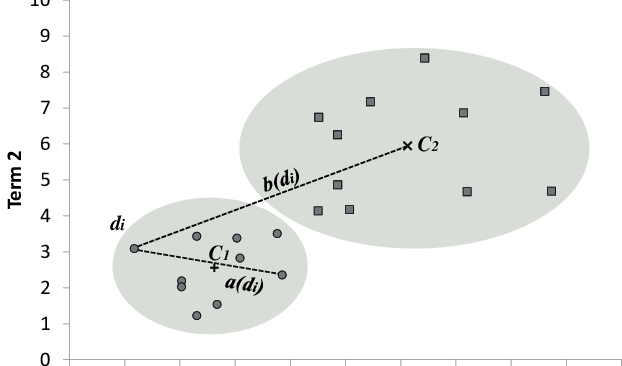

2) Calinski-Harabasz Index (Индекс Калински-Харабаша или критерий коэффициента дисперсии)

Индекс представляет собой отношение суммы дисперсии между кластерами и дисперсии внутри кластера для всех кластеров (где дисперсия определяется как сумма квадратов расстояний).
Чем выше значение, тем лучше кластеризация.
Низкие значения указывают на:
- слабую разделимость кластеров (они перекрываются);
- избыточное дробление данных (слишком много кластеров).

Имеет следующие преимущества:
- высокая скорость вычисления (быстрее силуэтного коэффициента);
- хорошо работает для больших данных;
- чувствителен к соотношению "разделимость/компактность".

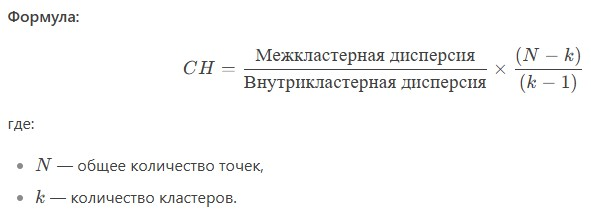

Формула данного критерия состоит из следующих компонентов.

а) межкластерная дисперсия - сумма квадратов расстояний между центроидами кластеров и общим центром данных.
Показывает насколько далеко кластеры разнесены друг от друга.
Чем выше SSB, тем лучше кластеры разделены.
Рассчитывается по следующей формуле:

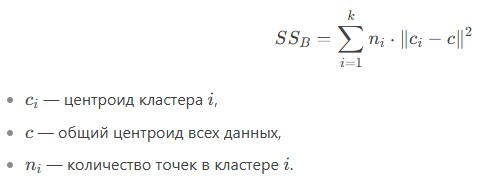

б) внутрикластерная дисперсия - сумма квадратов расстояний между точками и центроидом их кластера.
Показывает насколько компактны кластеры.
Чем меньше SSW, тем плотнее точки внутри кластеров.
Формула представлена на рисунке.

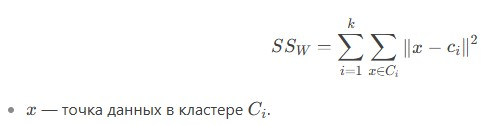

в) нормирующий множитель
Корректирует оценку с учётом количества кластеров k и точек N.
Предотвращает завышение оценки при большом k.

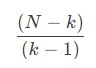

3) Davies-Bouldin Index (DBI или Индекс Дэвиса-Болдина)

Этот индекс обозначает среднее «сходство» между кластерами, где сходство – это мера, которая сравнивает расстояние между кластерами с размером самих кластеров. Более низкий индекс Дэвиса-Болдина относится к модели с лучшим
разделением кластеров.

Идеальная кластеризация:
- кластеры компактные (малые расстояния внутри кластера);
- кластеры далеко друг от друга (большие расстояния между центрами кластеров).

Формула представлена на рисунке ниже.

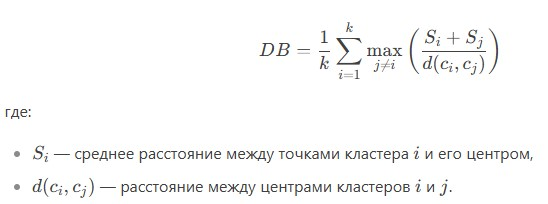

Формула состоит из следующих переменных:

а) мера разброса кластера Si:
Обычно вычисляется как среднее расстояние между точками кластера и его центроидом:

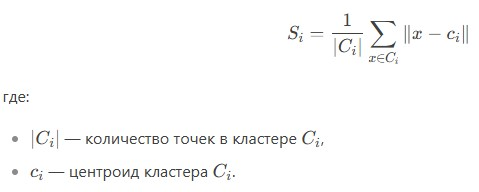

б) расстояние между кластерами d(ci, cj):
Чаще всего — евклидово расстояние между центроидами:

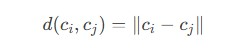

Если кластеры пересекаются (d(ci,cj))≈0), индекс резко возрастает → плохая кластеризация.
Таким образом, применяется следующая интерпретация значений:

Значение DBI/Качество кластеризации
< 0.5. Отличное разделение;
0.5–1.0.	Хорошее/удовлетворительное;
> 1.0	Плохое (кластеры пересекаются или слиты).

Преимущества использования данной метрики:
- простота вычисления — требует только центроидов и попарных расстояний;
- интуитивная интерпретация — чем меньше, тем лучше;
- универсальность — работает для любых метрик расстояния (евклидова, манхэттенская и др.);
- учет компактности и разделимости — в отличие от CH, не требует предположений о форме кластеров.

#### 7.2. Применение метрик оценки качества кластеризации

1. Функция для оценки качества кластеризации
На вход принимает:
- X. Масштабированные данные (например, distances_scaled);
- labels. Метки кластеров;
- eps и min_samples. Параметры DBSCAN (для вывода в консоль).
Затем функция проверяет, что кластеров больше 1 (иначе метрики не работают).
Вычисляет три метрики и выводит их значения.
Возвращает (silhouette, calinski, davies) или None, если кластер один.

2. Параметры для всех вариантов кластеризации
Данная запись представляет собой список словарей.
Словарь содержит пары "ключ:значение".
Ключи (например, eps, min_samples) — это строки (str).
Значения могут быть любого типа: числа, строки, переменные (например, clusters_1), DataFrame (results_df_1).
Каждый словарь описывает параметры одного варианта кластеризации:
- eps (float). максимальное расстояние между соседями): 0.1, 0.3, 0.5 (параметр DBSCAN);
- min_samples (int). Минимальное количество точек для образования кластера: 1 или 2 (параметр DBSCAN);
- clusters (array-like). Массив с метками кластеров, полученный после выполнения DBSCAN;
- df (DataFrame). Таблица Pandas с исходными данными и результатами кластеризации.
Данный этап необходим для того, чтобы сравнить, как разные параметры влияют на качество кластеризации.

3. Оценка кластеризации
Предметная цель данного фрагмента кода:
Определить, какие параметры DBSCAN (eps и min_samples) дают наилучшее разделение данных на кластеры с точки зрения:
- чёткости границ между кластерами;
- баланса между компактностью и разделимостью;
- процента шумовых точек (выбросов).

3.1. Итерация по параметрам кластеризации
cluster_params — это список словарей, где каждый словарь содержит параметры одного варианта кластеризации.
Данный цикл перебирает все комбинации параметров для их поочерёдной оценки.

3.2. Извлечение параметров
Подготовка параметров для передачи в функцию оценки.

3.3.  Оценка качества кластеризации
Вызывается функция evaluate_clustering, которая принимает:
- distances_scaled — масштабированные данные (например, расстояния между точками);
- clusters — метки кластеров;
- eps и min_samples — для информативного вывода в консоль.
Функция возвращает три метрики:
- silhouette — коэффициент силуэта (чем ближе к 1, тем лучше);
- calinski — индекс Калински-Харабаша (чем выше, тем лучше);
- davies — индекс Дэвиса-Болдина (чем ближе к 0, тем лучше).

3.4. Анализ распределения кластеров
np.unique(clusters, return_counts=True):
Возвращает уникальные метки кластеров (unique) и количество точек в каждом (counts).
noise_percent — процент шумовых точек (метка -1):
Формула: (число шумовых точек) / (общее число точек) * 100%.

3.5. Сохранение результатов
В список results сохраняется:
Ключ/значение:
- eps. Параметр eps DBSCAN;
- min_samples. Параметр min_samples DBSCAN;
- silhouette. Коэффициент силуэта;
- calinski. Индекс Калински-Харабаша;
- davies. Индекс Дэвиса-Болдина;
- n_clusters. Число кластеров (без учёта шума -1);
- noise_percent. Процент шума;
- cluster_distribution. Распределение точек по кластерам (словарь {метка: количество}).

n_clusters вычисляется как:
len(np.unique(clusters)) - (1 if -1 in clusters else 0)
Если есть шум (-1), он исключается из подсчёта кластеров.

Итоговый результат выполнения 3-го шага:
После выполнения цикла results содержит список словарей с метриками для всех вариантов параметров.

4. Вывод распределения кластеров
Необходим, чтобы показать статистику по каждому кластеру и проценту шума (выбросов).
Выводит количество точек в каждом кластере и их процентное соотношение.
Отдельно выводит процент точек, помеченных как шум (-1 в DBSCAN).
Форматирует вывод с точностью до одного знака после запятой.

5. Создание сводной таблицы метрик
Цель: сравнить качество кластеризации при разных параметрах DBSCAN (eps и min_samples).
Создает DataFrame из результатов (словаря с метками). 
Затем выводит таблицу с ключевыми метриками:
- eps, min_samples - параметры DBSCAN
- silhouette, calinski, davies - метрики качества кластеризации
- n_clusters - количество найденных кластеров
- noise_percent - процент шума
to_string(index=False) убирает вывод индексов для лучшей читаемости.

6. Визуализация метрик качества
Фрагмент кода позволяет графически сравнить качество кластеризации при разных значениях eps.
Создает 3 вертикальных subplot
Для каждой метрики (Silhouette, Calinski-Harabasz, Davies-Bouldin):
- строит график зависимости метрики от параметра eps;
- добавляет подписи и заголовки с пояснениями;
- включает сетку для лучшей читаемости;
- использует маркеры 'o-' для точек и линий.

7. Визуализация кластеров
Целью является визуализация распределения точек по кластерам для разных параметров DBSCAN.
Создает сетку 2x3 для визуализации.
Для каждого набора параметров:
1) Рисует scatter plot, где:
- X: идентификатор маршрута (индекс);
- Y: отклонение от идеального маршрута в метрах;
- цвет: номер кластера (использует colormap 'viridis').
2) Добавляет colorbar для идентификации кластеров.
3) Указывает параметры eps и min_samples в заголовке.
alpha=0.6 делает точки полупрозрачными для лучшего восприятия перекрывающихся точек.



Оценка кластеризации DBSCAN (eps=0.5, min_samples=2):
Silhouette Score: 0.2177
Calinski-Harabasz Index: 2.3108
Davies-Bouldin Index: 1.0004
Распределение кластеров:
  Кластер -1: 8 точек (50.0%)
  Кластер 0: 2 точек (12.5%)
  Кластер 1: 3 точек (18.8%)
  Кластер 2: 3 точек (18.8%)
Процент шума: 50.0%


Оценка кластеризации DBSCAN (eps=0.3, min_samples=2):
Silhouette Score: 0.7094
Calinski-Harabasz Index: 37.2525
Davies-Bouldin Index: 0.5061
Распределение кластеров:
  Кластер -1: 2 точек (12.5%)
  Кластер 0: 14 точек (87.5%)
Процент шума: 12.5%


Оценка кластеризации DBSCAN (eps=0.1, min_samples=2):
Silhouette Score: 0.6407
Calinski-Harabasz Index: 22.0282
Davies-Bouldin Index: 0.4135
Распределение кластеров:
  Кластер -1: 2 точек (12.5%)
  Кластер 0: 5 точек (31.2%)
  Кластер 1: 3 точек (18.8%)
  Кластер 2: 3 точек (18.8%)
  Кластер 3: 3 точек (18.8%)
Процент шума: 12.5%


Оценка кластеризации DBSCAN (eps=0.5, min_samples=1):
Silhouette Score: 0.5633
Calinski-Harabasz Index: 32.4988
D

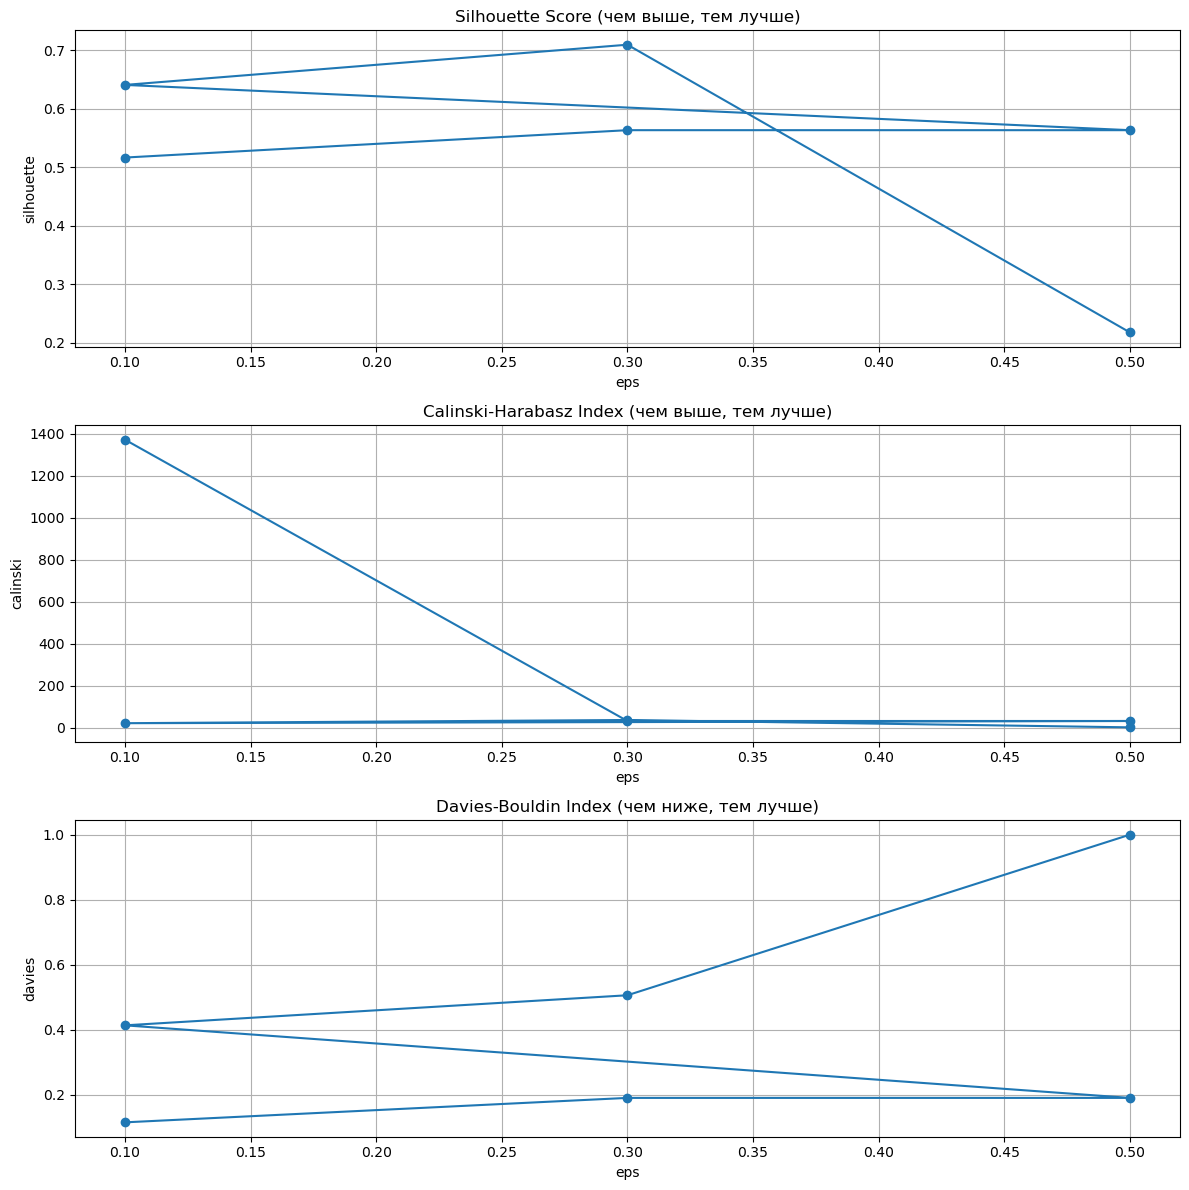

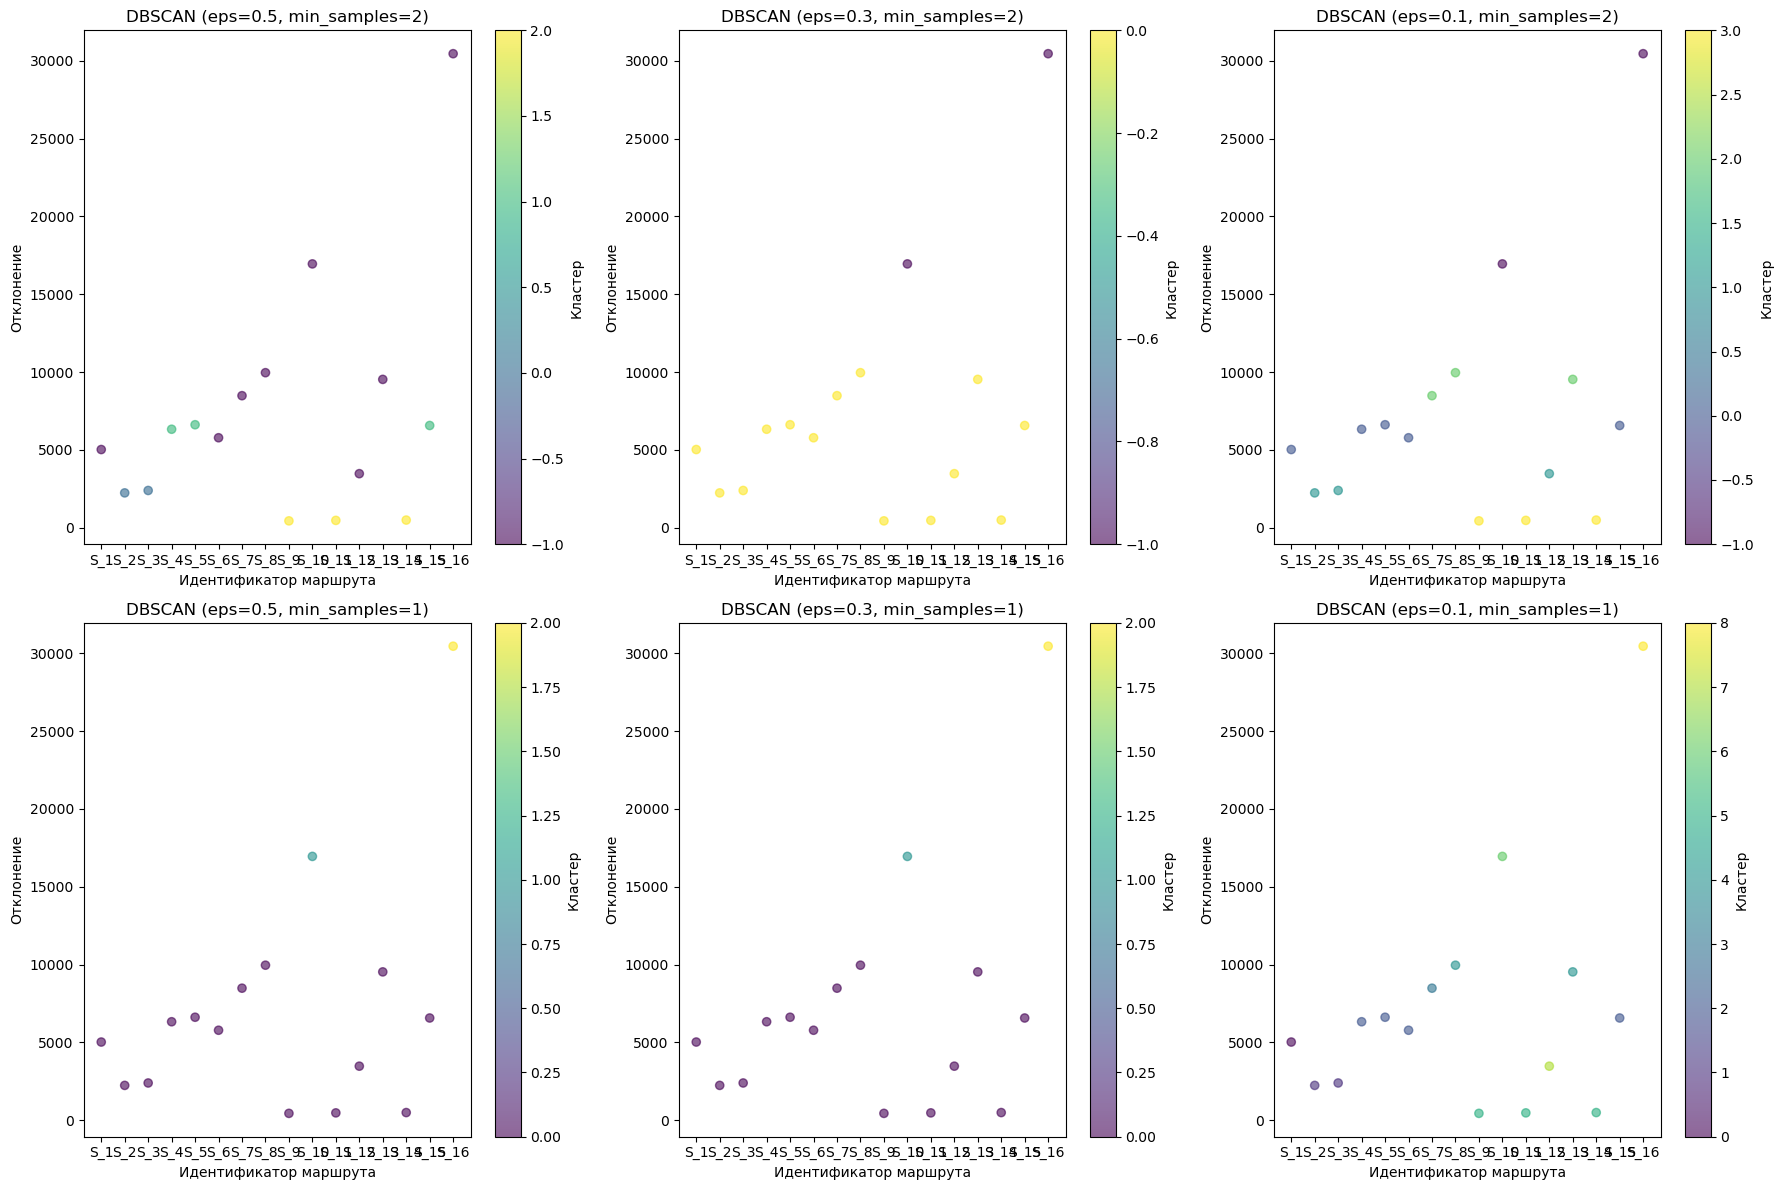

In [102]:
# 1. Функция для оценки качества кластеризации
def evaluate_clustering(X, labels, eps=None, min_samples=None):
    if eps is not None and min_samples is not None:
        print(f"\nОценка кластеризации DBSCAN (eps={eps}, min_samples={min_samples}):")
    
    if len(np.unique(labels)) > 1:  # Для этих метрик нужно хотя бы 2 кластера
        silhouette = silhouette_score(X, labels)
        calinski = calinski_harabasz_score(X, labels)
        davies = davies_bouldin_score(X, labels)
        
        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"Calinski-Harabasz Index: {calinski:.4f}")
        print(f"Davies-Bouldin Index: {davies:.4f}")
        return silhouette, calinski, davies
    else:
        print("Недостаточно кластеров для оценки (только 1 кластер)")
        return None, None, None

# 2. Параметры для всех вариантов кластеризации
cluster_params = [
    {'eps': 0.5, 'min_samples': 2, 'clusters': clusters_1, 'df': results_df_1},
    {'eps': 0.3, 'min_samples': 2, 'clusters': clusters_2, 'df': results_df_2},
    {'eps': 0.1, 'min_samples': 2, 'clusters': clusters_3, 'df': results_df_3},
    {'eps': 0.5, 'min_samples': 1, 'clusters': clusters_4, 'df': results_df_4},
    {'eps': 0.3, 'min_samples': 1, 'clusters': clusters_5, 'df': results_df_5},
    {'eps': 0.1, 'min_samples': 1, 'clusters': clusters_6, 'df': results_df_6}
]

# 3. Оценка кластеризации
# Создаем список для хранения результатов
results = []

# 3.1. Итерация по параметрам кластеризации
for params in cluster_params:
    # 3.2. Извлечение параметров
    eps = params['eps']
    min_samples = params['min_samples']
    clusters = params['clusters']
    df = params['df']
    
    # 3.3.  Оценка качества кластеризации
    silhouette, calinski, davies = evaluate_clustering(
        distances_scaled, 
        clusters,
        eps=eps,
        min_samples=min_samples
    )
    
    # 3.4. Анализ распределения кластеров
    unique, counts = np.unique(clusters, return_counts=True)
    noise_percent = np.sum(clusters == -1)/len(clusters)
    
    # 3.5. Сохранение результатов
    results.append({
        'eps': eps,
        'min_samples': min_samples,
        'silhouette': silhouette,
        'calinski': calinski,
        'davies': davies,
        'n_clusters': len(np.unique(clusters)) - (1 if -1 in clusters else 0),
        'noise_percent': noise_percent,
        'cluster_distribution': dict(zip(unique, counts))
    })
    
    # 4. Вывод распределения кластеров
    print(f"Распределение кластеров:")
    for cluster, count in zip(unique, counts):
        print(f"  Кластер {cluster}: {count} точек ({count/len(clusters):.1%})")
    print(f"Процент шума: {noise_percent:.1%}\n")

# 5. Создание сводной таблицы метрик
results_df = pd.DataFrame(results)

# Сравнение результатов в таблице
print("\nСводная таблица метрик для всех вариантов кластеризации:")
print(results_df[['eps', 'min_samples', 'silhouette', 'calinski', 'davies', 
                 'n_clusters', 'noise_percent']].to_string(index=False))

# 6. Визуализация метрик качества
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

metrics_to_plot = ['silhouette', 'calinski', 'davies']
titles = ['Silhouette Score (чем выше, тем лучше)', 
          'Calinski-Harabasz Index (чем выше, тем лучше)',
          'Davies-Bouldin Index (чем ниже, тем лучше)']

for ax, metric, title in zip(axes, metrics_to_plot, titles):
    ax.plot(results_df['eps'], results_df[metric], 'o-')
    ax.set_title(title)
    ax.set_xlabel('eps')
    ax.set_ylabel(metric)
    ax.grid(True)

plt.tight_layout()
plt.show()

# 7. Визуализация кластеров
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for ax, params in zip(axes, cluster_params):
    eps = params['eps']
    min_samples = params['min_samples']
    clusters = params['clusters']
    df = params['df']
    
    scatter = ax.scatter(df.index, df['Distance'], c=clusters, cmap='viridis', alpha=0.6)
    ax.set_title(f'DBSCAN (eps={eps}, min_samples={min_samples})')
    ax.set_xlabel('Идентификатор маршрута')
    ax.set_ylabel('Отклонение')
    plt.colorbar(scatter, ax=ax, label='Кластер')

plt.tight_layout()
plt.show()

Из всего вышесказанного, необходимо по рассчитанным метрикам оценки качества кластеризации определить, с какими параметрами DBSCAN наиболее точно и качественно производит кластеризацию маршрутов.
Так,
- silhouette — коэффициент силуэта (чем ближе к 1, тем лучше);
- calinski — индекс Калински-Харабаша (чем выше, тем лучше);
- davies — индекс Дэвиса-Болдина (чем ближе к 0, тем лучше).

На основе полученной сводной таблицы метрик для всех вариантов кластеризации в результате выполнения предыдущего фрагмента кода, можно сделать вывод о том, что наилучшие результаты кластеризации достигаются при параметрах eps=0.1, min_samples=1.
Так как именно при такой комбинации все три метрики приближены к идеальным:
silhouette=0.516501;
calinski=1370.519809;
davies=0.114854.

Наихудшим вариантом подбора параметров является eps=0.1 и min_samples=2, так как
silhouette=0.640679;
calinski=22.028162;
davies=0.413512.

### 8. Выявление и визуализация наилучшего и наихудшего маршрутов по результатам наиболее точной кластеризации

#### 8.1. Определение наилучшего и наихудшего маршрута

Этот фрагмент кода выполняет анализ маршрутов на основе данных, хранящихся в DataFrame results_df_6, и выводит информацию о наилучшем и наихудшем маршрутах по отклонению от эталонного.
Основная цель:
- определить маршруты с минимальным и максимальным отклонением от идеальной траектории;
- извлечь их номера и кластерную принадлежность (если данные кластеризованы);
- вывести информацию в читаемом формате.

1. Нахождение наилучшего маршрута
results_df_6['Distance'] — обращение к столбцу Distance в DataFrame, где хранятся отклонения маршрутов от эталона.
.idxmin() — метод, возвращающий индекс строки с минимальным значением в столбце.
Результат: best_route содержит название строки (например, S_5), соответствующей маршруту с наименьшим отклонением.

best_num = int(best_route.split('_')[1])
best_route.split('_') — разбивает строку (например, S_5) по символу _, получая список ['S', '5'].
[1] — берёт второй элемент списка (индекс 1), то есть номер маршрута (5).
int(...) — преобразует строку в число (например, '5' → 5).
Результат: best_num содержит номер маршрута (например, 5).

best_cluster = results_df_6.loc[best_route, 'Cluster']
results_df_6.loc[best_route, 'Cluster'] — обращается к DataFrame по индексу best_route и берёт значение из столбца Cluster.
Результат: best_cluster содержит номер кластера, к которому относится лучший маршрут (например, 0 — "Очень хорошие").

2. Нахождение наихудшего маршрута
worst_route = results_df_6['Distance'].idxmax()
Аналогично idxmin(), но ищет максимальное отклонение.
Результат: worst_route содержит название строки (например, S_12), соответствующей маршруту с наибольшим отклонением.

worst_num = int(worst_route.split('_')[1])
Аналогично best_num, но для худшего маршрута.
Результат: worst_num содержит номер маршрута (например, 12).

worst_cluster = results_df_6.loc[worst_route, 'Cluster']
Аналогично best_cluster, но для худшего маршрута.
Результат: worst_cluster содержит номер кластера (например, 6 — "Очень плохие").

3. Вывод результатов
Форматированная строка (f-string) выводит: 
- actual_{best_num} — номер лучшего маршрута (например, actual_5);
- (Кластер {best_cluster}) — его кластер (например, Кластер 0);
- {results_df_6.loc[best_route, 'Distance']:.2f} м — отклонение в метрах, округлённое до 2 знаков (например, 15.23 м).
Аналогичный вывод и для худшего маршрута.


In [37]:
# 1. Нахождение наилучшего маршрута
best_route = results_df_6['Distance'].idxmin()
best_num = int(best_route.split('_')[1])
best_cluster = results_df_6.loc[best_route, 'Cluster']

# 2. Нахождение наихудшего маршрута
worst_route = results_df_6['Distance'].idxmax()
worst_num = int(worst_route.split('_')[1])
worst_cluster = results_df_6.loc[worst_route, 'Cluster']

# 3. Вывод результатов
print(f"Наилучший маршрут: actual_{best_num} (Кластер {best_cluster}) с отклонением {results_df_6.loc[best_route, 'Distance']:.2f} м")
print(f"Наихудший маршрут: actual_{worst_num} (Кластер {worst_cluster}) с отклонением {results_df_6.loc[worst_route, 'Distance']:.2f} м")

Наилучший маршрут: actual_9 (Кластер 5) с отклонением 444.96 м
Наихудший маршрут: actual_16 (Кластер 8) с отклонением 30457.20 м


#### 8.2. Визуализация маршрутов

1. Функция для нахождения точки начала значительного отклонения
Определяет  точку, где фактический маршрут начинает существенно отклоняться от эталонного.
ideal_route: Координаты эталонного маршрута;
actual_route: Координаты анализируемого маршрута;
threshold: Порог отклонения в метрах (по умолчанию 87м).
Последовательно сравнивает соответствующие точки маршрутов.
Использует geodesic() для расчета расстояния между точками.
Возвращает индекс первой точки, где отклонение > threshold.
Если отклонений нет - возвращает последнюю точку.
Использует точное географическое расстояние (геодезическое)
enumerate сохраняет порядковый номер точки.

2. Создание карты
Цель: создать интерактивную карту с визуализацией двух маршрутов и меткой начала отклонения.
Базовая карта:
- центрируется по средним координатам (map_center);
- масштаб 15 (уровень улиц);
- использует OpenStreetMap.
Линии маршрутов:
1) Эталонный. Красный (#FF0000), толщина 5px.
2) Анализируемый:
- лучший: ярко-зеленый (lime);
- худший: фиолетовый (#80F - hex-код).
Прозрачность 70-80% для наглядности.
Метка отклонения:
Фиолетовый маркер с иконкой "восклицательный знак", а также всплывающая подсказка с номером точки.
Легенда - фиксированный HTML-блок в левом нижнем углу, который содержит:
- название маршрута;
- величину отклонения;
- цветовые обозначения;
- пояснение метки.

3. Загрузка данных маршрутов
Создание функции load_route()
Обрабатывает отсутствие файла;
Возвращает None при ошибке (для последующей проверки);
Использует pandas для чтения CSV.

4. Выполнение визуализации
4.1. Загрузка данных для лучшего и худшего маршрутов
Использует созданную на предыдущем шаге функцию load_route().
4.2. Подготовка координат
4.3. Создание и отображение карты
По результатам 4-го шага на выходе:
- две интерактивные карты Folium;
- наглядное сравнение с эталоном;
- точное определение начала отклонений;
- информативные подписи и легенды.

In [38]:
# 1. Функция для нахождения точки начала значительного отклонения
def find_deviation_start(ideal_route, actual_route, threshold=87):  # threshold в метрах
    """Находит первую точку, где отклонение превышает заданный порог"""
    for i, (ideal_pt, actual_pt) in enumerate(zip(ideal_route, actual_route)):
        if geodesic(ideal_pt, actual_pt).meters > threshold:
            return i
    return len(ideal_route) - 1  # Если отклонение не найдено, возвращаем последнюю точку

# 2. Создание карты
def create_simple_route_map(ideal_points, actual_points, actual_num, distance, title_suffix, is_best=True):

    m = folium.Map(location=map_center, zoom_start=15, tiles='OpenStreetMap')
    
    # Эталонный маршрут (красный)
    folium.PolyLine(
        locations=[[p[0], p[1]] for p in ideal_points],
        color='red',
        weight=5,
        opacity=0.8,
        tooltip='Эталонный маршрут'
    ).add_to(m)
    
    # Сравниваемый маршрут (зелёный для лучшего, тёмно-красный для худшего)
    route_color = 'lime' if is_best else '#80F'
    folium.PolyLine(
        locations=[[p[0], p[1]] for p in actual_points],
        color=route_color,
        weight=4,
        opacity=0.7,
        tooltip=f'Маршрут {actual_num}'
    ).add_to(m)
    
    # Находим и отмечаем начало отклонения
    deviation_idx = find_deviation_start(ideal_points, actual_points)
    deviation_point = actual_points[deviation_idx]
    
    folium.Marker(
        location=deviation_point,
        icon=folium.Icon(color='darkpurple', icon='exclamation-circle', prefix='fa'),
        tooltip=f'Начало отклонения (точка {deviation_idx+1})'
    ).add_to(m)
    
    # Добавляем легенду
    legend_html = f'''
        <div style="position: fixed; 
                    bottom: 50px; left: 50px; width: 320px; 
                    border:2px solid grey; z-index:9999; font-size:14px;
                    background-color:white; padding:10px;">
            <b>{title_suffix}</b><br>
            <b>Маршрут {actual_num}</b><br>
            Отклонение: {distance:.2f} м<br>
            <span style="color:red">———</span> Эталонный маршрут<br>
            <span style="color:{route_color}">———</span> Маршрут {actual_num}<br>
            <i class="fa fa-exclamation-circle" style="color:darkpurple"></i> Начало отклонения
        </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# 3. Загрузка данных маршрутов
def load_route(num):
    try:
        return pd.read_csv(f"actual{num}_mnogo_to4ek.csv", sep=',')
    except FileNotFoundError:
        print(f"Файл actual{num}_mnogo_to4ek.csv не найден")
        return None

# 4. Выполнение визуализации
# 4.1. Загрузка данных для лучшего и худшего маршрутов
best_route_data = load_route(best_num)
worst_route_data = load_route(worst_num)

if best_route_data is not None and worst_route_data is not None:
    # 4.2. Подготовка координат
    ideal_points = list(zip(ideal['X'], ideal['Y']))
    best_points = list(zip(best_route_data['X'], best_route_data['Y']))
    worst_points = list(zip(worst_route_data['X'], worst_route_data['Y']))
    
    # 4.3. Создание и отображение карты
    best_map = create_simple_route_map(
        ideal_points,
        best_points,
        best_num,
        results_df_6.loc[best_route, 'Distance'],
        "Лучший маршрут (минимальное отклонение)",
        is_best=True
    )
    
    worst_map = create_simple_route_map(
        ideal_points,
        worst_points,
        worst_num,
        results_df_6.loc[worst_route, 'Distance'],
        "Худший маршрут (максимальное отклонение)",
        is_best=False
    )
    
    # Отображаем карты
    display(best_map)
    display(worst_map)
else:
    print("Не удалось загрузить данные для одного из маршрутов")